# Projekt nr 5

Przeysław Rola, Juliusz Wasieleski, grupa 1, rok 2, Informatyka WIEiT

Styczeń 2023

### Import bibliotek

In [261]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
from sortedcontainers import SortedList
import json as js

In [262]:
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [263]:
%matplotlib notebook
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Definiuję funkcje pomocnicze

In [264]:
EPS = 1e-12
def orient(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

# Wczytywanie wielokątu

Podaj kolejne punkty korzystając z opcji dodaj punkt i klikając w wybrane miejsce na wykresie (punkty muszą być podane w kierunku przeciwnym do kierunku wskazówek zegara)

<IPython.core.display.Javascript object>


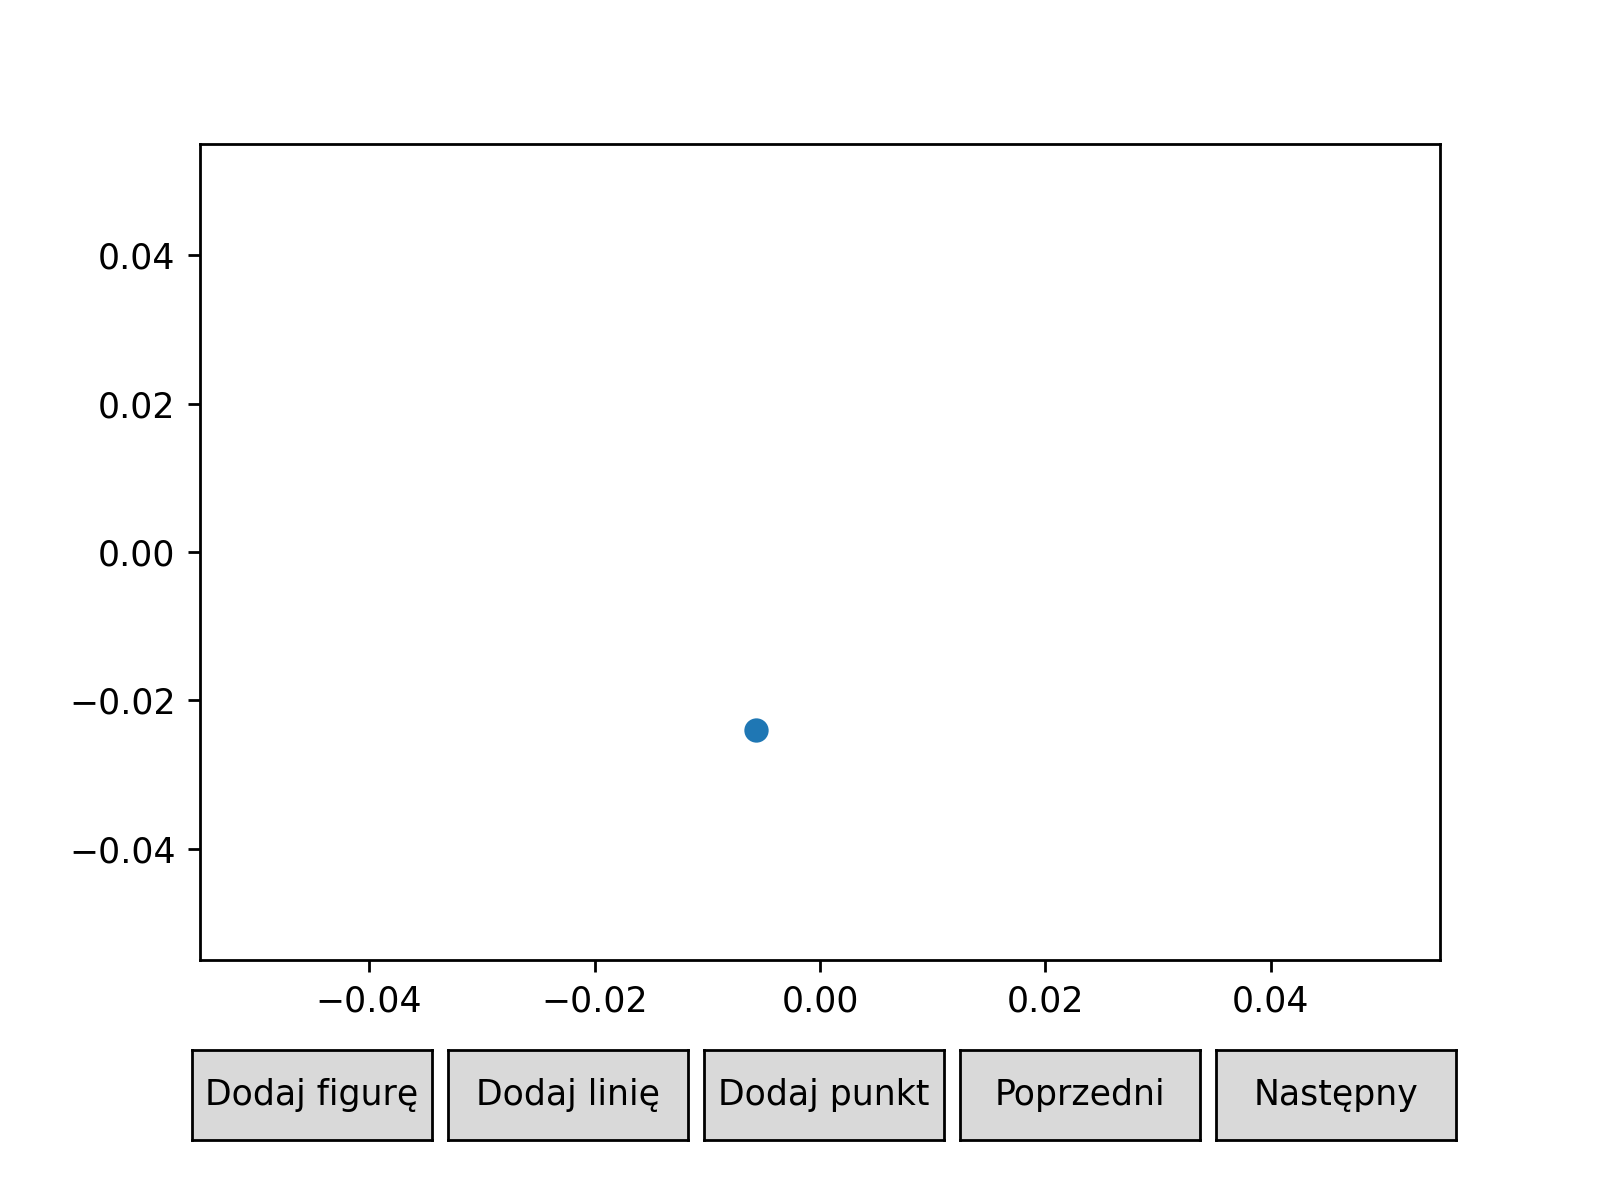

In [265]:
input_plot = Plot()
input_plot.draw()

In [266]:
input_points = input_plot.get_added_points()[0].points

## Zapisywanie do pliku i czytanie z pliku

In [267]:
def save_polygon_to_file(points):
    filename = input("Podaj nazwę pliku: ")
    output = open('tests/' + filename + '.txt', "w")
    for point in points:
        output.write(str(point[0]) + ' ' + str(point[1]) + '\n')
    output.close()
    
save_polygon_to_file(input_points)   

Podaj nazwę pliku: test


In [268]:
def read_from_file(path):
    P = []
    read = open(path, 'r')
    for line in read:
        P.append(list(map(float, line.split())))
    return P

# Klasyfikacja wierzchołków

Przyjmuję konwencję z wykładu:

<ul>
    1- green (zielony) - starting (wierzchołek początkowy),<br>
    2- red (czerwony) - ending (wierzchołek końcowy),<br>
    3- dark blue (ciemnoniebieski) - connective (wierzchołek łączący),<br>
    4- light blue (jasnoniebieski) - separative (wierzchołek dzielący),<br>
    5- saddlebrown (brązowy) - correct (wierzchołek prawidłowy).<br>
</ul>

In [269]:
def qualify_vertexes(p):
    n = len(p)
    
    beginning_points  =  []
    ending_points     =  []
    connecting_points =  []
    dividing_points   =  []
    correct_points    =  []
    lines             =  []
    
    for i in range(n):
        prev_point = p[(i-1)%n]
        current_point = p[i]
        next_point = p[(i+1)%n]
        
        o = orient(prev_point.get_cords(), current_point.get_cords(), next_point.get_cords())
        above = 0
        under = 0
        
        if prev_point.get_cords()[1] > current_point.get_cords()[1]:
            above += 1
        if next_point.get_cords()[1] > current_point.get_cords()[1]:
            above += 1
        if prev_point.get_cords()[1] < current_point.get_cords()[1]:
            under += 1
        if next_point.get_cords()[1] < current_point.get_cords()[1]:
            under += 1

        if under == 2:
            if o > EPS:
                beginning_points.append(current_point.get_cords())
                current_point.type = 1
            else:
                dividing_points.append(current_point.get_cords())
                current_point.type = 4
        elif above == 2:
            if o > EPS:
                ending_points.append(current_point.get_cords())
                current_point.type = 2
            else:
                connecting_points.append(current_point.get_cords())
                current_point.type = 3
        else:
            correct_points.append(current_point.get_cords())
            current_point.type = 5
        
        lines.append((current_point.get_cords(), next_point.get_cords()))
    
    
    return beginning_points, ending_points, connecting_points, dividing_points, correct_points, lines

#print(orient([0.03246774058188161, -0.02612949174993178],[0.03224596638833323, -0.006919932926402361],[0.02537096638833322 -0.006919932926402361]))


In [270]:
def draw_points(input_points):
    n = len(input_points)
    beginning_points, ending_points, connecting_points, dividing_points, correct_points, lines = qualify_vertexes(input_points)
    #lines = convert_to_lines(input_points)
    print('Poczatkowych: ' + str(len(beginning_points)))
    print('Koncowych: ' + str(len(ending_points)))
    print('Łączących: ' + str(len(connecting_points)))
    print('Dzielących: ' + str(len(dividing_points)))
    print('Prawidłowych: ' + str(len(correct_points)))
    print('Lacznie wierzcholkow: ' + str(n))
    scene = [Scene([PointsCollection(beginning_points, color = 'yellow'),
                   PointsCollection(ending_points, color = 'red'),
                   PointsCollection(connecting_points, color = 'purple'),
                   PointsCollection(dividing_points, color = 'blue'),
                   PointsCollection(correct_points, color = 'black')],
                  [LinesCollection(lines)])]
    
    qualify_plot = Plot(scene)
    qualify_plot.draw()

#### Klasyfikacja punktów dla punktów z testów 7, 8, 9 i 10

Poczatkowych: 3
Koncowych: 2
Łączących: 2
Dzielących: 1
Prawidłowych: 37
Lacznie wierzcholkow: 45


<IPython.core.display.Javascript object>


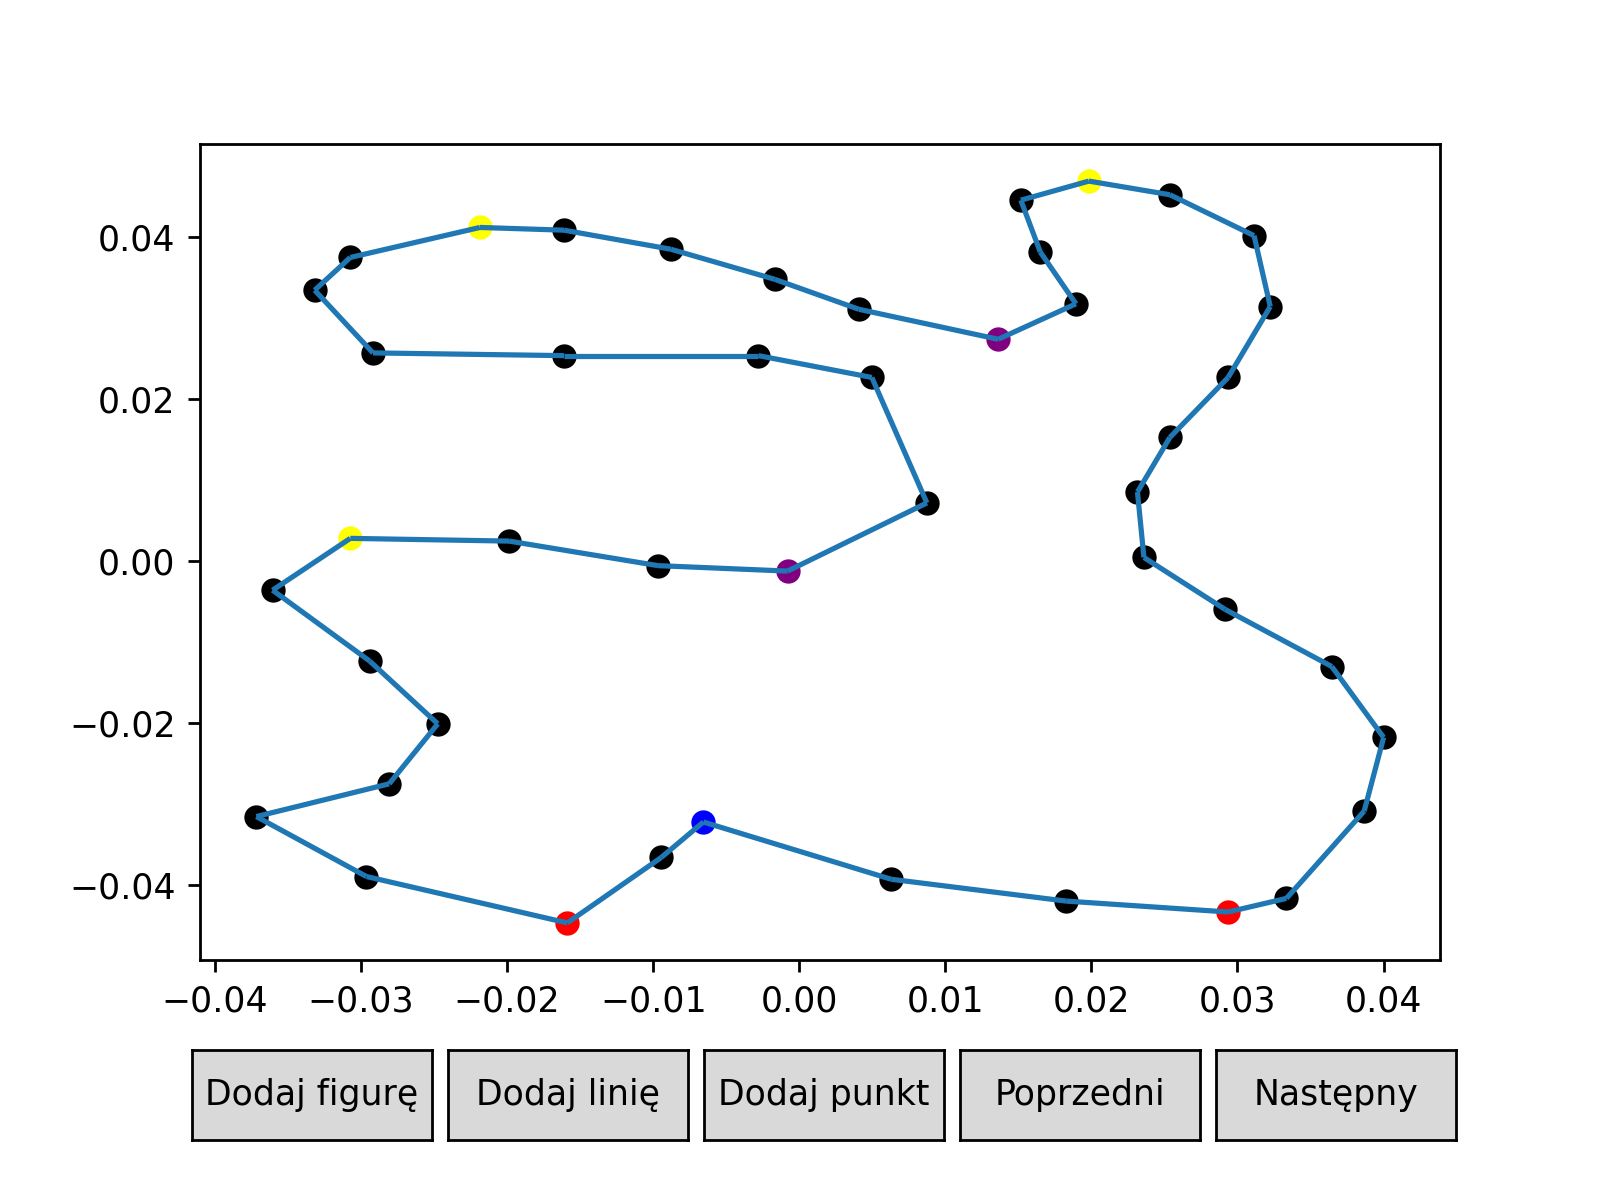

In [271]:
points, cos = map_to_points_and_lines(read_from_file('tests/test_1.txt'))
draw_points(points)

# Podział na wielokąty monotoniczne

## Klasy i funkcje pomocnicze

In [272]:
def map_to_points_and_lines(p):
    n = len(p)
    P = []
    L = []
    
    for i in range(0,n-1):
        p1 = pPoint(p[i][0], p[i][1])
        p2 = pPoint(p[i+1][0], p[i+1][1])
        p1.index = i
        P.append(p1)
        Line1 = Line(p1,p2)
        
    p1 = pPoint(p[-1][0], p[-1][1])
    p2 = pPoint(p[0][0], p[0][1])
    P.append(p1)
    p1.index = n-1
    Line1 = Line(p1,p2)
    L = [(p[i], p[(i+1)%n]) for i in range(n)]
    return P, L


class pPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.chain = None
        self.index = None
        self.index_tmp = None
        self.type = None
    
    def set_chain(self, chain):
        self.chain = chain
    
    def get_cords(self):
        return (self.x, self.y)
    def get_type(self):
        return self.type
    
    
class Line:
    def __init__(self, p1, p2):
        self.point_1 = p1
        self.point_2 = p2

## Algorytm podziału

In [273]:
def split_into_monotonic(p, scenes):
    n = len(p)
    points, lines = map_to_points_and_lines(p)
    qualify_vertexes(points)
    points_sorted = sorted(points, key=lambda v: v.y, reverse=True)
    state = SortedList()
    new_diagonals = []
    for i in range(n):
        # print(points_sorted[i].get_cords(), points_sorted[i].type)

        # początkowy
        if points_sorted[i].type == 1:
            ind = points_sorted[i].index
            state.add((ind + 1) % n)
            # indeks dalszego punktu tej krawędzi jest wrzucany do struktury stanu

        # końcowy
        elif points_sorted[i].type == 2:
            ind = points_sorted[i].index
            cords_1 = points_sorted[i].get_cords()
            cords_2 = points[(ind + 1) % n].get_cords()
            i_new = i - 1

            while points_sorted[i_new].index != (ind + 1) % n and orient(cords_1, cords_2,
                                                                         points_sorted[i_new].get_cords()) < -EPS:
                i_new -= 1
            if points_sorted[i_new].type == 3:
                new_diagonals.append(sorted([ind, points_sorted[i_new].index]))

            state.remove(points_sorted[i].index)

        # łączący
        elif points_sorted[i].type == 3:
            ind = points_sorted[i].index
            # znjadź pomocniika ep i moze połącz
            cords_1 = points_sorted[i].get_cords()
            cords_2 = points[(ind - 1) % n].get_cords()
            i_new = i - 1
            while points_sorted[i_new].index != ind - 1 and orient(cords_1, cords_2,
                                                                   points_sorted[i_new].get_cords()) > EPS:
                i_new -= 1
            if points_sorted[i_new].type == 3:
                new_diagonals.append(sorted([points_sorted[i].index, points_sorted[i_new].index]))

            # znajdź ev
            # TODO
            state_i = 0
            while len(state)>state_i and orient(points[state._getitem(state_i)].get_cords(),
                         points[(state._getitem(state_i) - 1) % n].get_cords(),
                         points_sorted[i].get_cords()) < 0:
                state_i = (state_i + 1) % n
            ev = state._getitem(state_i - 1)

            # znajdź pomocnika ev i może połącz
            cords_1 = points_sorted[i].get_cords()
            cords_2 = points[(ind - 1) % n].get_cords()
            i_new = i - 1
            while points_sorted[i_new].index != (ind - 1) % n and orient(cords_1, cords_2,
                                                                         points_sorted[i_new].get_cords()) > EPS:
                i_new -= 1
            if points_sorted[i_new].type == 3:
                new_diagonals.append(sorted([points_sorted[i].index, points_sorted[i_new].index]))

        # dzielący
        elif points_sorted[i].type == 4:
            ind = points_sorted[i].index
            # TODO
            state_i = 0
            while len(state)>state_i and orient(points[state._getitem(state_i)].get_cords(),
                         points[(state._getitem(state_i) - 1) % n].get_cords(),
                         points_sorted[i].get_cords()) < 0:
                state_i = (state_i + 1) % n
            ev = state._getitem(state_i - 1)

            cords_1 = points_sorted[i].get_cords()
            cords_2 = points[(ind - 1) % n].get_cords()
            i_new = i-1
            while points_sorted[i_new].index != ind - 1 and orient(cords_1, cords_2,
                                                                   points_sorted[i_new].get_cords()) > EPS:
                i_new -= 1

            new_diagonals.append(sorted([points_sorted[i_new].index, points_sorted[i].index]))
            state.add((ind + 1) % n)



        # prawidłowy
        elif points_sorted[i].type == 5:
            ind = points_sorted[i].index

            # jak wnętrze jest na prawo
            if points[ind].y < points[ind - 1].y:

                # szukamy pomocnika eg i jak jest łączący to dodajemy przekątną
                cords_1 = points_sorted[i].get_cords()
                cords_2 = points[(ind - 1) % n].get_cords()
                i_new = i - 1
                while points_sorted[i_new].index != ind - 1 and orient(cords_1, cords_2,
                                                                       points_sorted[i_new].get_cords()) > EPS:
                    i_new -= 1
                if points_sorted[i_new].type == 3:
                    new_diagonals.append(sorted([points_sorted[i].index, points_sorted[i_new].index]))

                # usuń eg i dodaj ed
                state.remove(points_sorted[i].index)
                state.add(points[(ind + 1)%n].index)

            # jak wnętrze jest na lewo
            else:
                # znajdź ev
                state_i = 0
                while state_i < len(state) and orient(points[state._getitem(state_i)].get_cords(),
                                                      points[(state._getitem(state_i) - 1) % n].get_cords(),
                                                      points_sorted[i].get_cords()) < -EPS:
                    state_i = (state_i + 1) % n

                #ev = state._getitem(state_i - 1)

                # znajdź pomocnika ev i może połącz
                cords_1 = points_sorted[i].get_cords()
                cords_2 = points[(ind - 1) % n].get_cords()
                i_new = i - 1
                while points_sorted[i_new].index != ind - 1 and orient(cords_1, cords_2,
                                                                       points_sorted[i_new].get_cords()) > EPS:
                    i_new -= 1
                if points_sorted[i_new].type == 3:
                    new_diagonals.append(sorted([points_sorted[i].index, points_sorted[i_new].index]))

    new_diagonals.sort(key=lambda v: v[0])
    begginings = [i[0] for i in new_diagonals]
    endings = [i[1] for i in new_diagonals]
    output = []
    output_iter = 0
    are_included = [False for _ in range(n)]
    begginings_included = [True for _ in range(len(begginings))]
    for i in range(n):
        if not are_included[i]:
            output.append([])
            i_tmp = i
            # cały wielokąt
            while not are_included[i_tmp]:
                # jeden ciąg
                if i_tmp not in begginings or not begginings_included[begginings.index(i_tmp)]:
                    output[output_iter].append(i_tmp)
                    are_included[i_tmp] = True
                    i_tmp = (i_tmp + 1) % n
                    while i_tmp not in begginings and not are_included[i_tmp]:
                        output[output_iter].append(i_tmp)
                        are_included[i_tmp] = True
                        i_tmp = (i_tmp + 1) % n
                    if i_tmp != 0:
                        output[output_iter].append(i_tmp)
                        if i_tmp in begginings:
                            begginings_included[begginings.index(i_tmp)] = False
                            i_tmp = endings[begginings.index(i_tmp)]
                        else:
                            i_tmp = begginings[endings.index(i_tmp)]
                else:
                    output[output_iter].append(i_tmp)
                    #begginings_included[begginings.index(i_tmp)] = True
                    i_tmp = endings[begginings.index(i_tmp)]

            output_iter += 1

    diagonals_to_show = []
    for i in new_diagonals:
        diagonals_to_show.append((points[i[0]].get_cords(), points[i[1]].get_cords()))

    scenes.append(Scene([PointsCollection(p)],
                         [LinesCollection(lines),
                          LinesCollection(diagonals_to_show)]))
    
    scenes.append(Scene([PointsCollection(p)],
                         [LinesCollection(lines),
                          LinesCollection(diagonals_to_show, color='red')]))

    return points, lines, output, diagonals_to_show
   


# Triangulacja

In [274]:
def inside_polygon(a, b, c, chain):  # funkcja sprawdzająca czy trójkąt złożony z punktów a,b,c leży całkowicie w wielokącie
    o = orient(a,b,c)
    
    if abs(o) < EPS:
        return False   # czy punkty są współniniowe
    
    if chain == 1:     # zależnie od łańcucha inaczej sprawdzam ten trójkąt
        return o < 0
    else:
        return o > 0
    

def do_not_follow(p1,p2,n): #czy punkty p1 i p2 nie są kolejnymi punktami w wieloącie (tzn czy międy p1 i p2 nie ma jeszcze krawędzi)
    return abs(p1.index_tmp - p2.index_tmp) != 1 and abs(p1.index_tmp - p2.index_tmp) != n-1
    
    
    
def triangulate_monotonic(points, L, polygon, scenes, diagonals_to_show, prev_diagonals, triangels):
    print()
    n = len(polygon)
    
    p = [points[i].get_cords() for i in range(len(points))]
    P = [points[i] for i in polygon]
    
    min_index = P.index(min(P, key = lambda v : v.y))
    max_index = P.index(max(P, key = lambda v : v.y))
    
    x = max_index           #uzupełnienie pól klasy point
    while x != min_index:
        P[x].chain = 1
        P[x].index_tmp = x
        x = (x+1)%n
    
    while x != max_index:
        P[x].chain = 2
        P[x].index_tmp = x
        x = (x+1)%n
    
    P = sorted(P, key = lambda v : v.y, reverse = True)    # sortowanie punktów
    
    stack = []
    stack.append(P[0])     #wrzucenie na stosu dwóch pierwszych punktów
    stack.append(P[1])
    scenes.append(Scene([PointsCollection(p)], [LinesCollection(L)]))
    scenes.append(Scene([PointsCollection(p),
                    PointsCollection([P[0].get_cords(), P[1].get_cords()], color = 'green')],
                    [LinesCollection(L),LinesCollection(diagonals_to_show, color = 'black')]))
    diagonals = []     # lista krawędzi wyrażonych floatami, do rysowania kolejnych scen
    diagonals_by_indexes=[]   # zwracana lista indeksów punktów między którymi ą krawędzie
    
    
    
    for i in range(2, n):
        scenes.append(Scene([PointsCollection(p),
                            PointsCollection([P[i].get_cords()], color = 'green')],
                            [LinesCollection(L + diagonals), LinesCollection(diagonals_to_show, color = 'black')]))
        if P[i].chain != stack[-1].chain:  # jeśli dwa punkty  nie są na tym samym łańcuchu
            first = stack[-1]
            #triangels.append((P[i].index,first.index, stack[-2].index))
            while len(stack) > 1:
                top = stack.pop()
                if do_not_follow(P[i], top, n):   #jeśli jeszcze nie ma krawędzi między tymi punktami
                    diagonals.append((P[i].get_cords(), top.get_cords()))
                    #triangels.append((P[i].index,top.index, stack[-2].index))
                    diagonals_by_indexes.append((P[i].index,top.index))
                    scenes.append(Scene([PointsCollection(p), 
                                         PointsCollection([P[i].get_cords(), top.get_cords()], color = 'red')], 
                                        [LinesCollection(L + diagonals), LinesCollection(diagonals_to_show, color = 'black')]))
            stack.pop()
            stack.append(first)
        else:      #jeśli dwa punkty są na tym samym łańcuchu
            top = stack.pop()
            top_prev = stack.pop()
            while inside_polygon(P[i].get_cords(), top.get_cords(), top_prev.get_cords(), P[i].chain):   #dopóki trójkąt tworzony przez t punkty jest wewnątrz wielokąta
                if do_not_follow(P[i], top_prev, n):  #jeśli jeszce nie ma kraedzi między tymi punktami
                    #triangels.append((P[i].index,top.index, top_prev.index))
                    diagonals.append((P[i].get_cords(), top_prev.get_cords()))
                    diagonals_by_indexes.append((P[i].index, top_prev.index))
                    scenes.append(Scene([PointsCollection(p), 
                                         PointsCollection([P[i].get_cords(), top_prev.get_cords()], color = 'red')], 
                                        [LinesCollection(L + diagonals), LinesCollection(diagonals_to_show, color = 'black')]))
                if not len(stack):
                    stack = stack + [top_prev]
                    break
                top, top_prev = top_prev, stack.pop()
            else:
                stack = stack + [top_prev, top]
        if stack[-1]!=P[i]:
            stack.append(P[i])
            
            
    
    
    scenes.append(Scene([PointsCollection(p)],
                       [LinesCollection(L),
                       LinesCollection(diagonals, color = 'red'), LinesCollection(prev_diagonals, color = 'black'), 
                        LinesCollection(diagonals_to_show, color = 'red')]))
    

    scenes.append(Scene(PointsCollection(p),[LinesCollection(L + diagonals),
                                            LinesCollection(prev_diagonals), 
                                             LinesCollection(diagonals_to_show, color = 'black')]))
    
    return diagonals_by_indexes, diagonals

In [275]:
def make_triangle(polygon, new_diagonals):
    n = len(polygon)
    triangle = []
    new_diagonals = [sorted(i) for i in new_diagonals]
    new_diagonals.sort(key=lambda v: v[0])
    begginings = [i[0] for i in new_diagonals]
    endings = [i[1] for i in new_diagonals]
    for i in range(len(polygon)):
        if polygon[(i+1)%n] in begginings:
            triangle.append((polygon[i], polygon[(i+1)%n], endings[begginings.index(polygon[(i+1)%n])]))
        if polygon[(i+1)%n] in endings:
            triangle.append((polygon[i], polygon[(i+1)%n], begginings[endings.index(polygon[(i+1)%n])]))
    return triangle
        
        
    
def triangulate(p):
    n = len(p)
    scenes = []
    triangels = []
    prev_diagonals = []
    points, lines, output, diagonals_to_show = split_into_monotonic(p, scenes)
    for polygon in output:
        diagonals_ind, diagonals_cords = triangulate_monotonic(points, lines, polygon, scenes, diagonals_to_show, prev_diagonals, triangels)
        triangle = make_triangle(polygon, diagonals_ind)
        triangels += triangle
        for i in diagonals_cords:
            prev_diagonals.append(i)
        
    plot = Plot(scenes)
    
    
    
    return plot, (points, triangels)
        

        


<IPython.core.display.Javascript object>


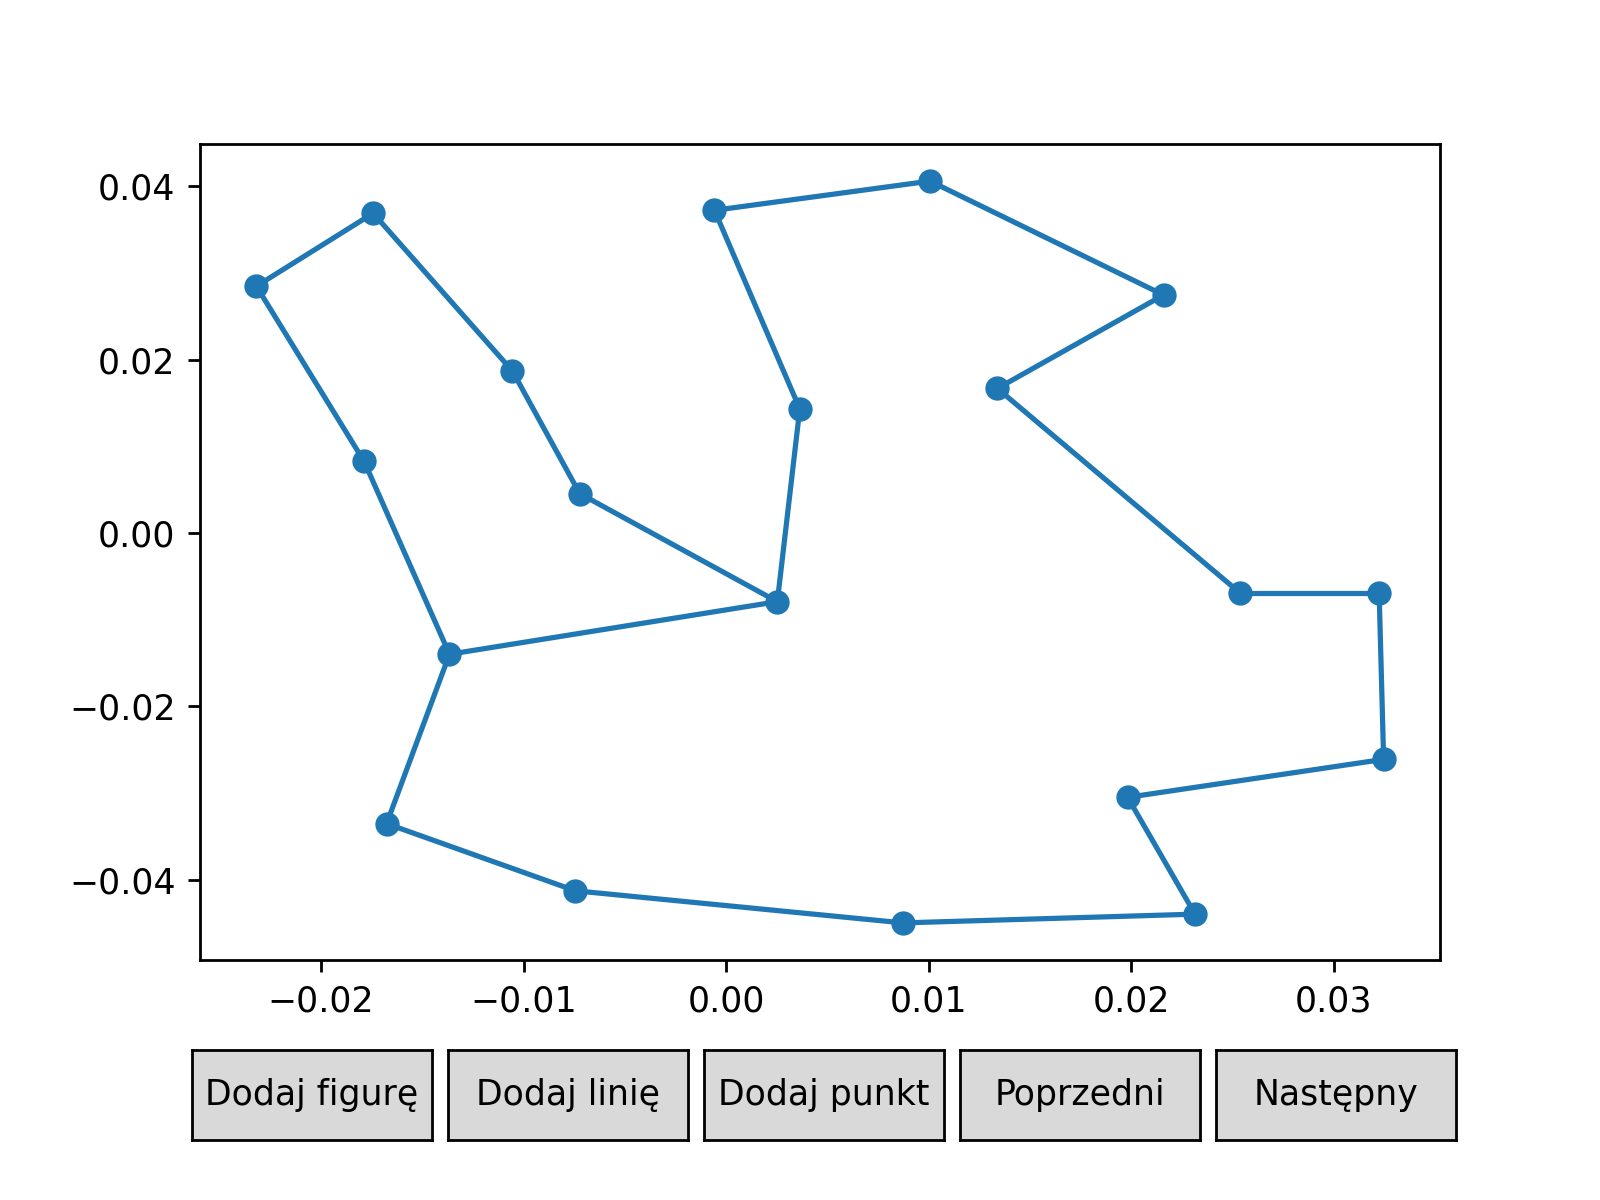

In [277]:
from time import time
plot,triangels = triangulate(read_from_file('tests/test_!.txt'))
plot.draw()

<IPython.core.display.Javascript object>


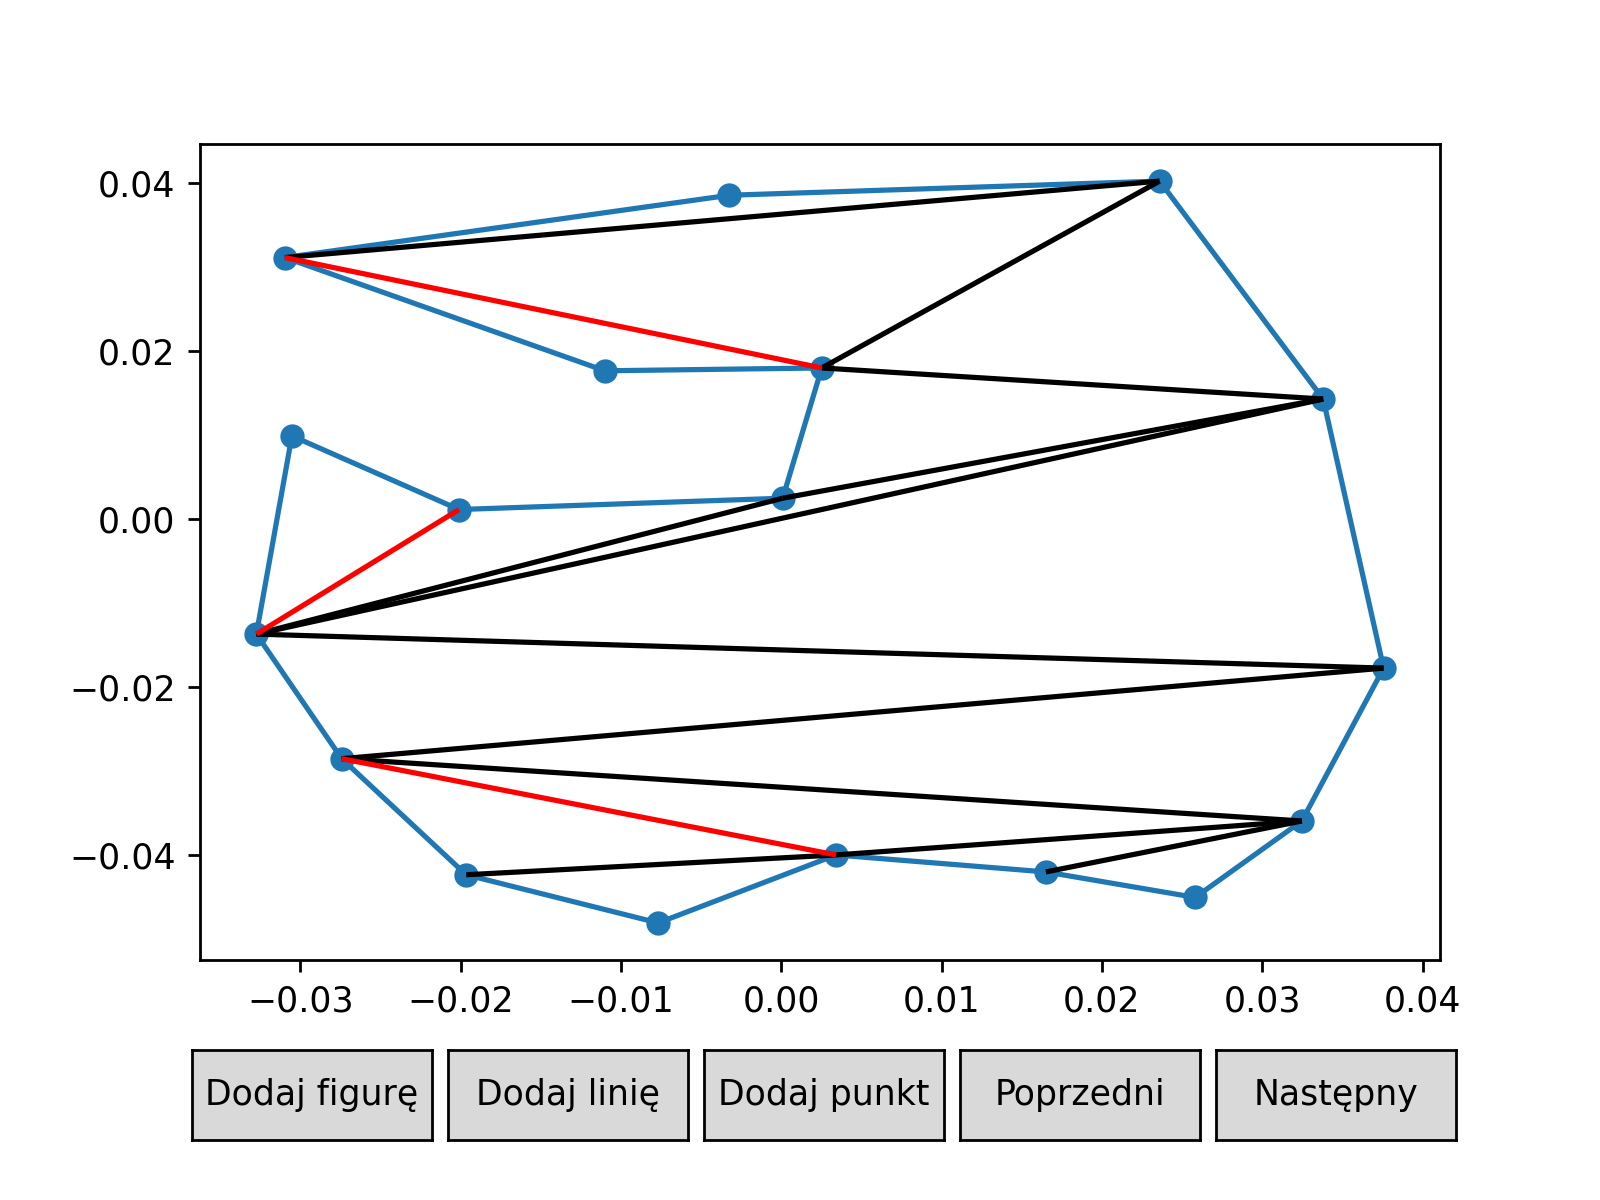

In [278]:
plot,triangels = triangulate(read_from_file('tests/test_2.txt'))
plot.draw()

<IPython.core.display.Javascript object>


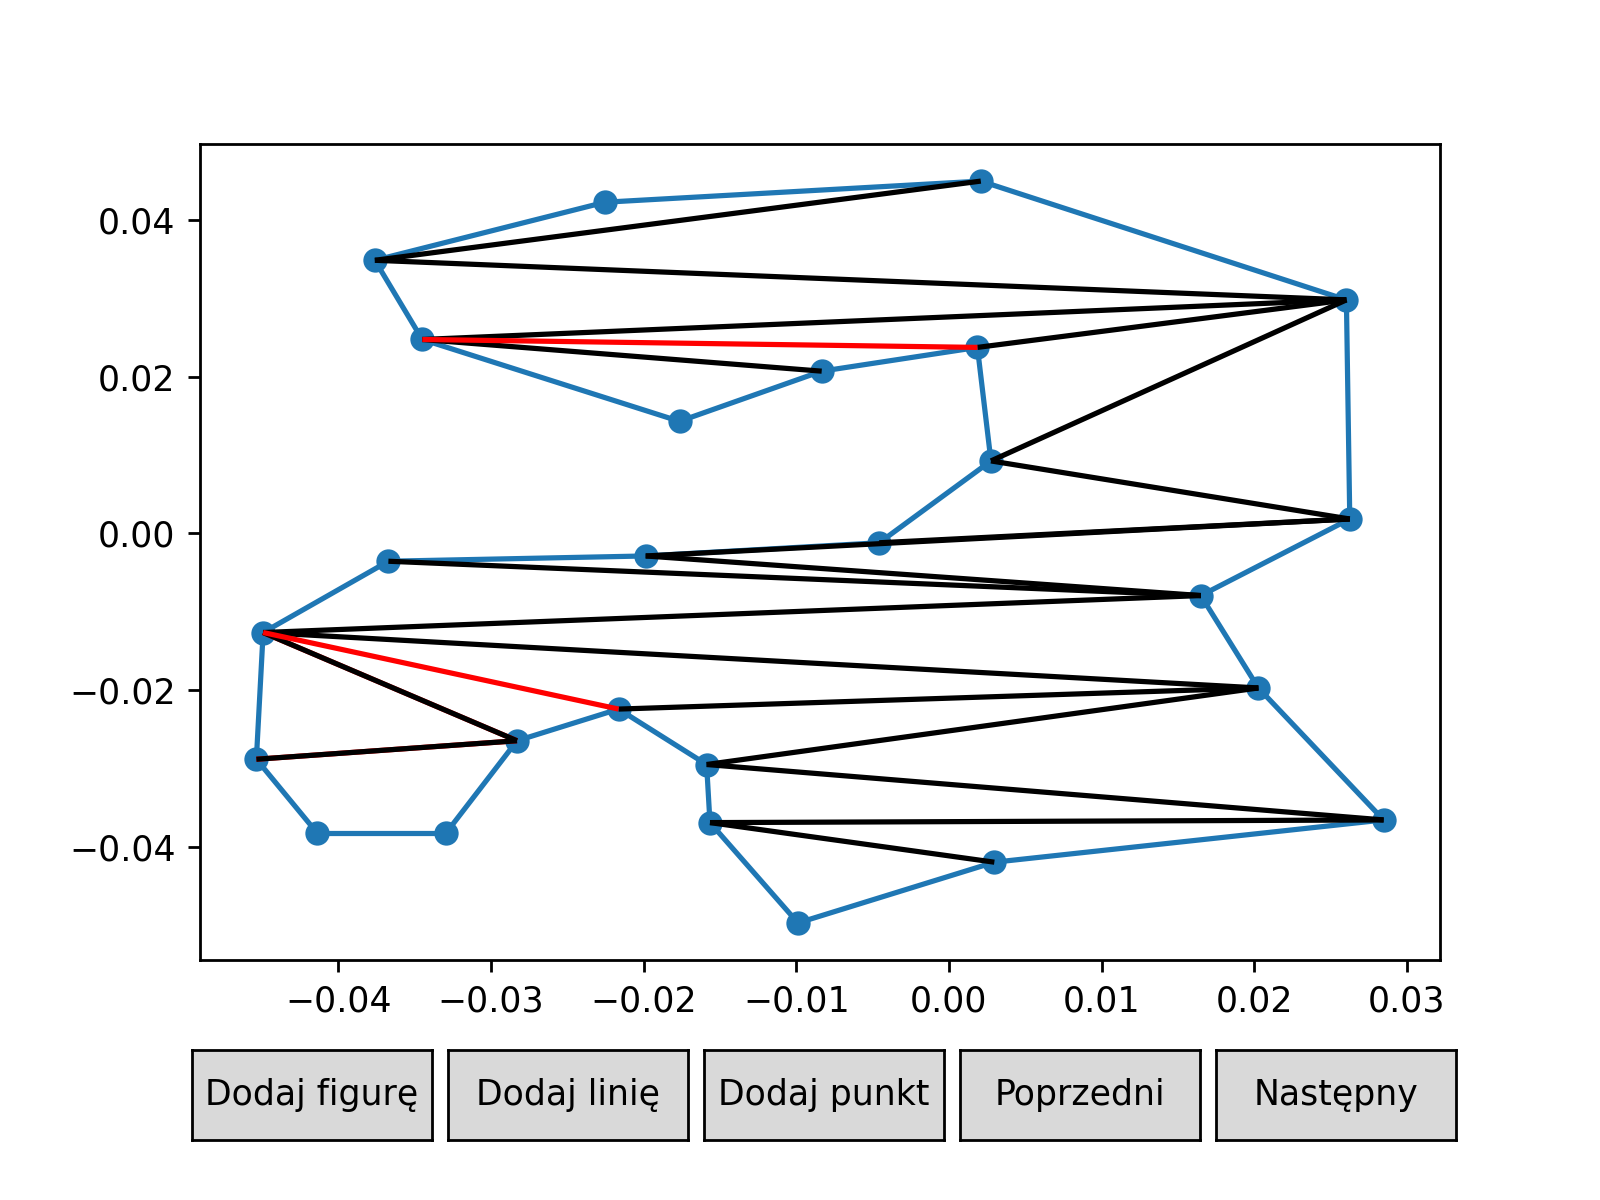

In [279]:
plot,triangels = triangulate(read_from_file('tests/test_3.txt'))
plot.draw()

<IPython.core.display.Javascript object>


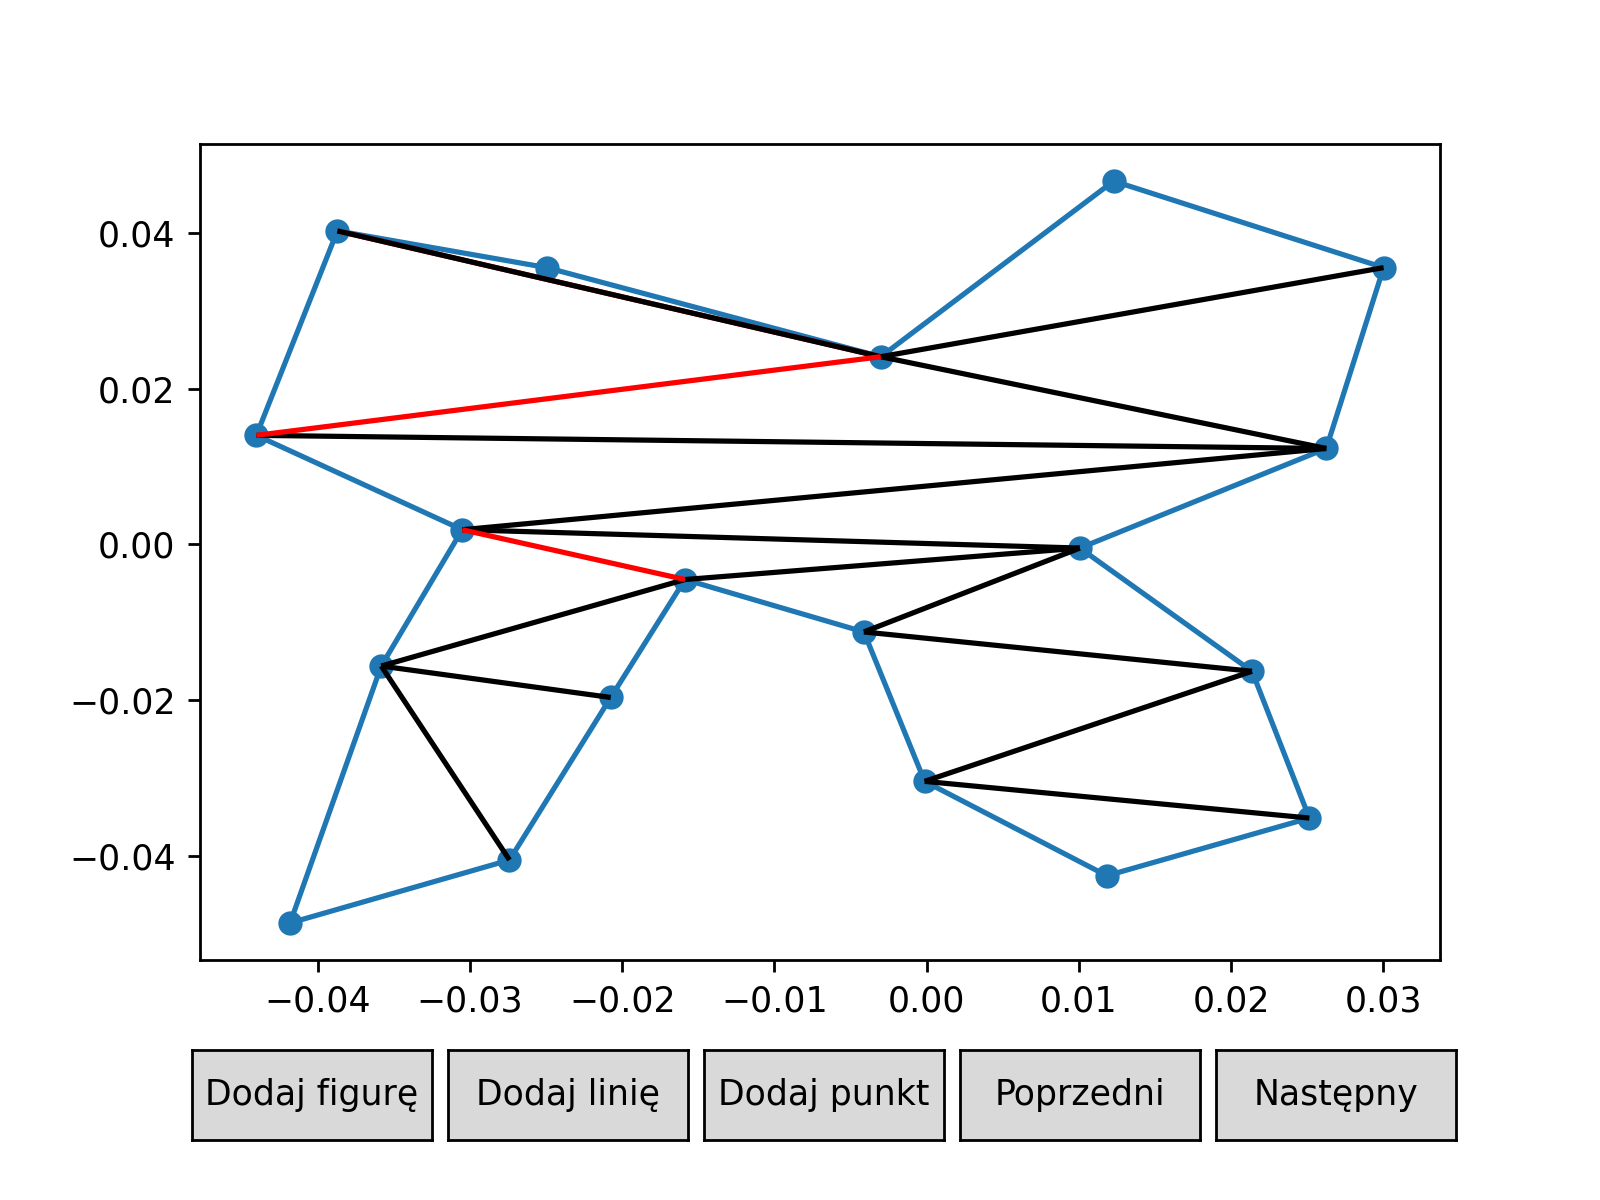

In [280]:
plot,triangels = triangulate(read_from_file('tests/test_4.txt'))
plot.draw()

<IPython.core.display.Javascript object>


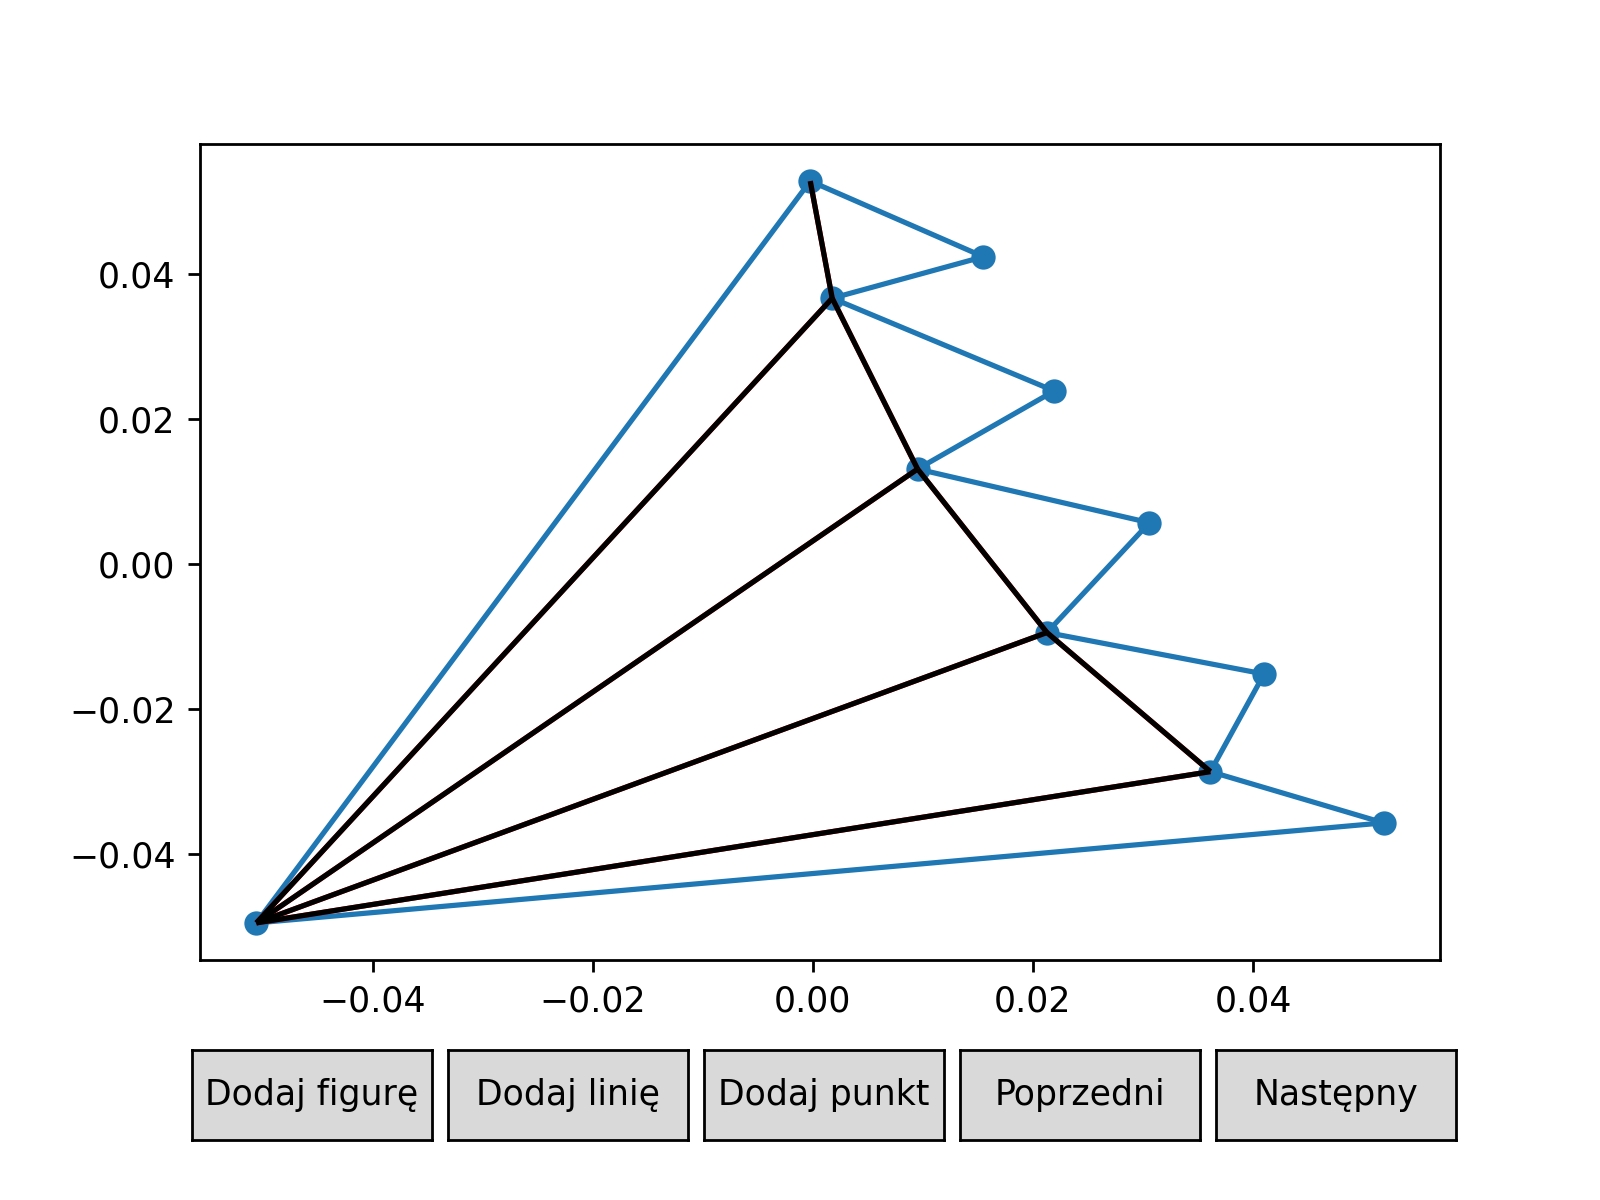

In [281]:
plot,triangels = triangulate(read_from_file('tests/test_5.txt'))
plot.draw()

<IPython.core.display.Javascript object>


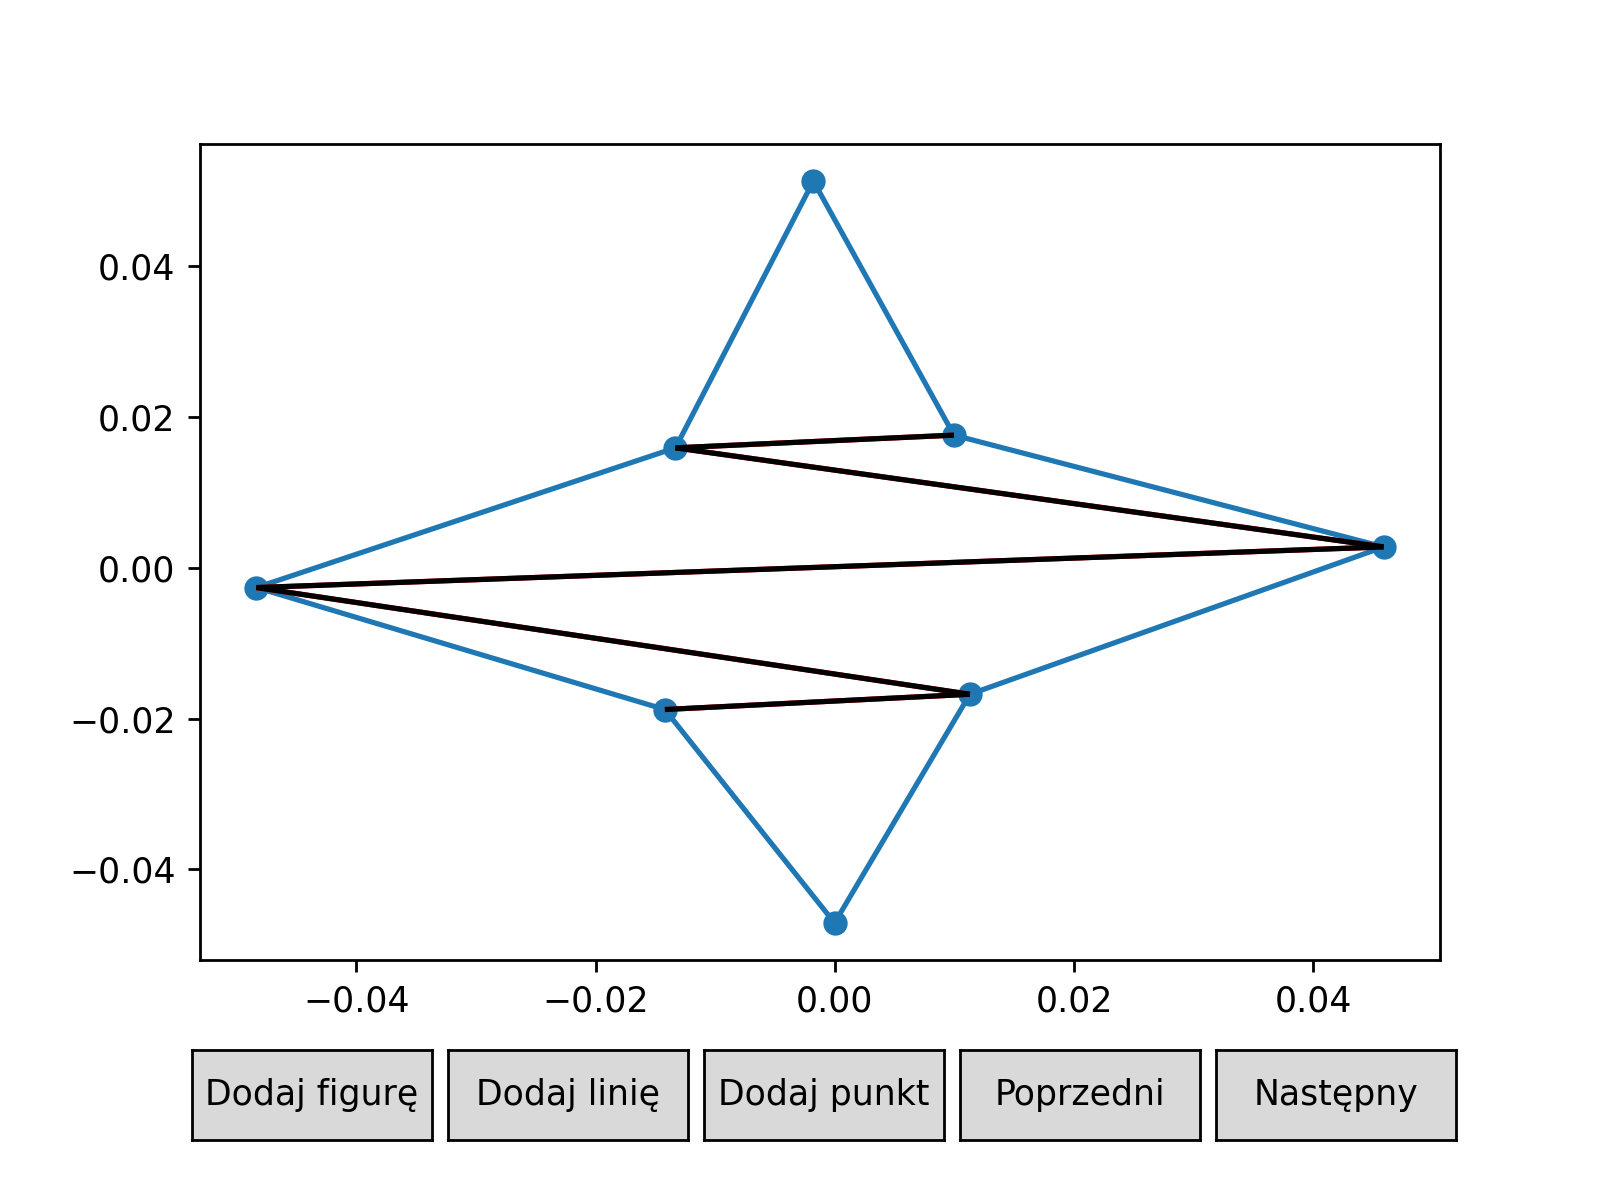

In [282]:
plot,triangels = triangulate(read_from_file('tests/test_6.txt'))
plot.draw()

<IPython.core.display.Javascript object>


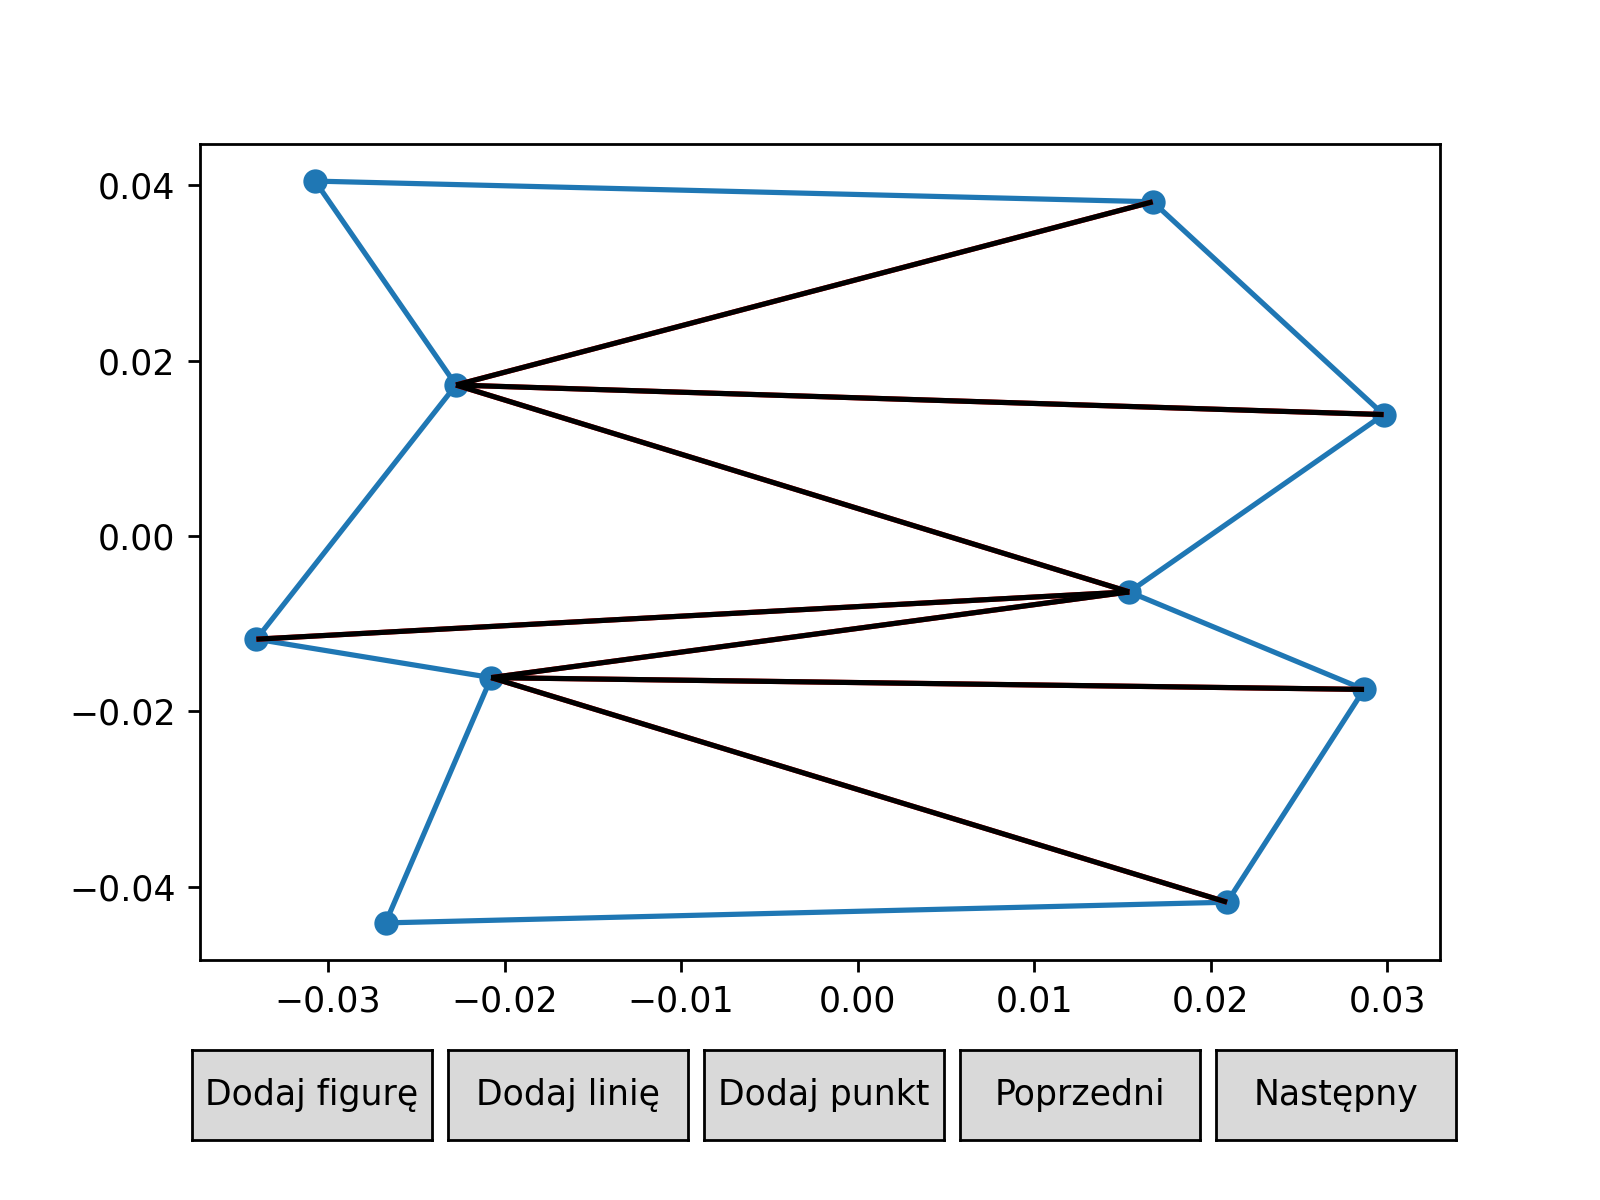

In [283]:
plot,triangels = triangulate(read_from_file('tests/test_7.txt'))
plot.draw()

<IPython.core.display.Javascript object>


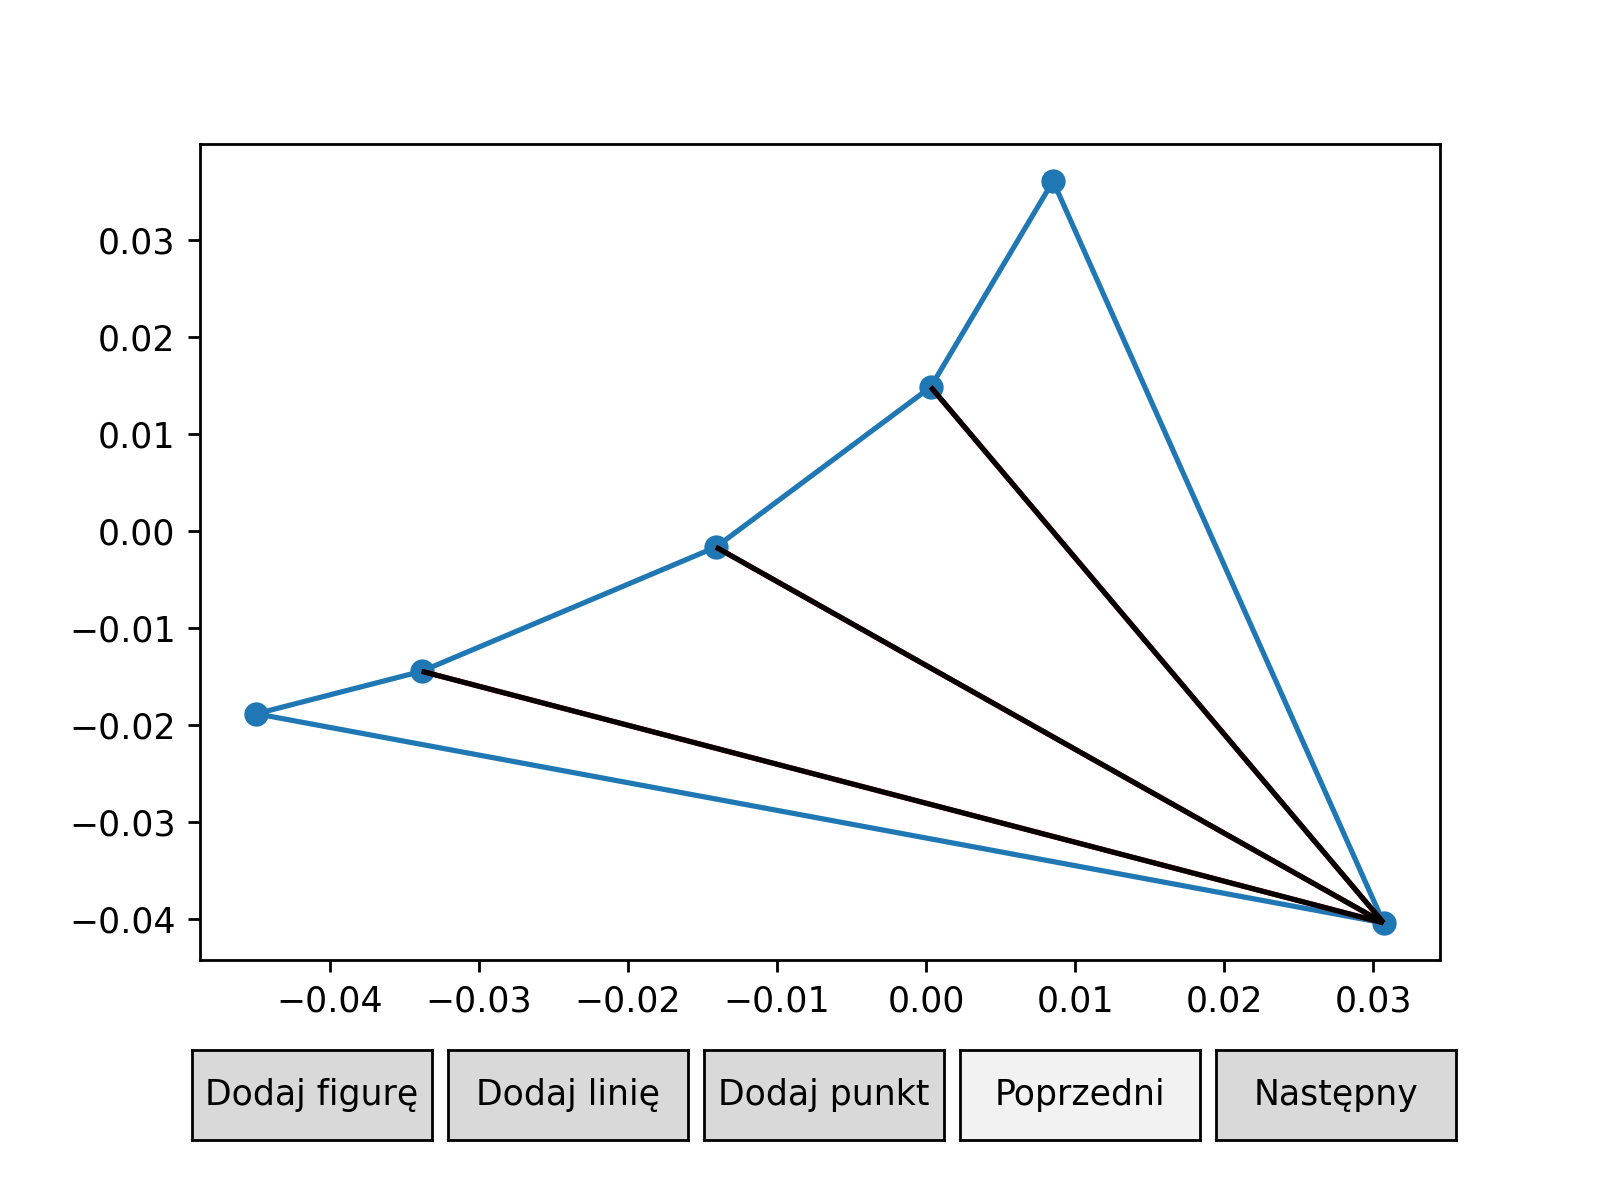

In [284]:
plot,triangels = triangulate(read_from_file('tests/test_10.txt'))
plot.draw()

<IPython.core.display.Javascript object>


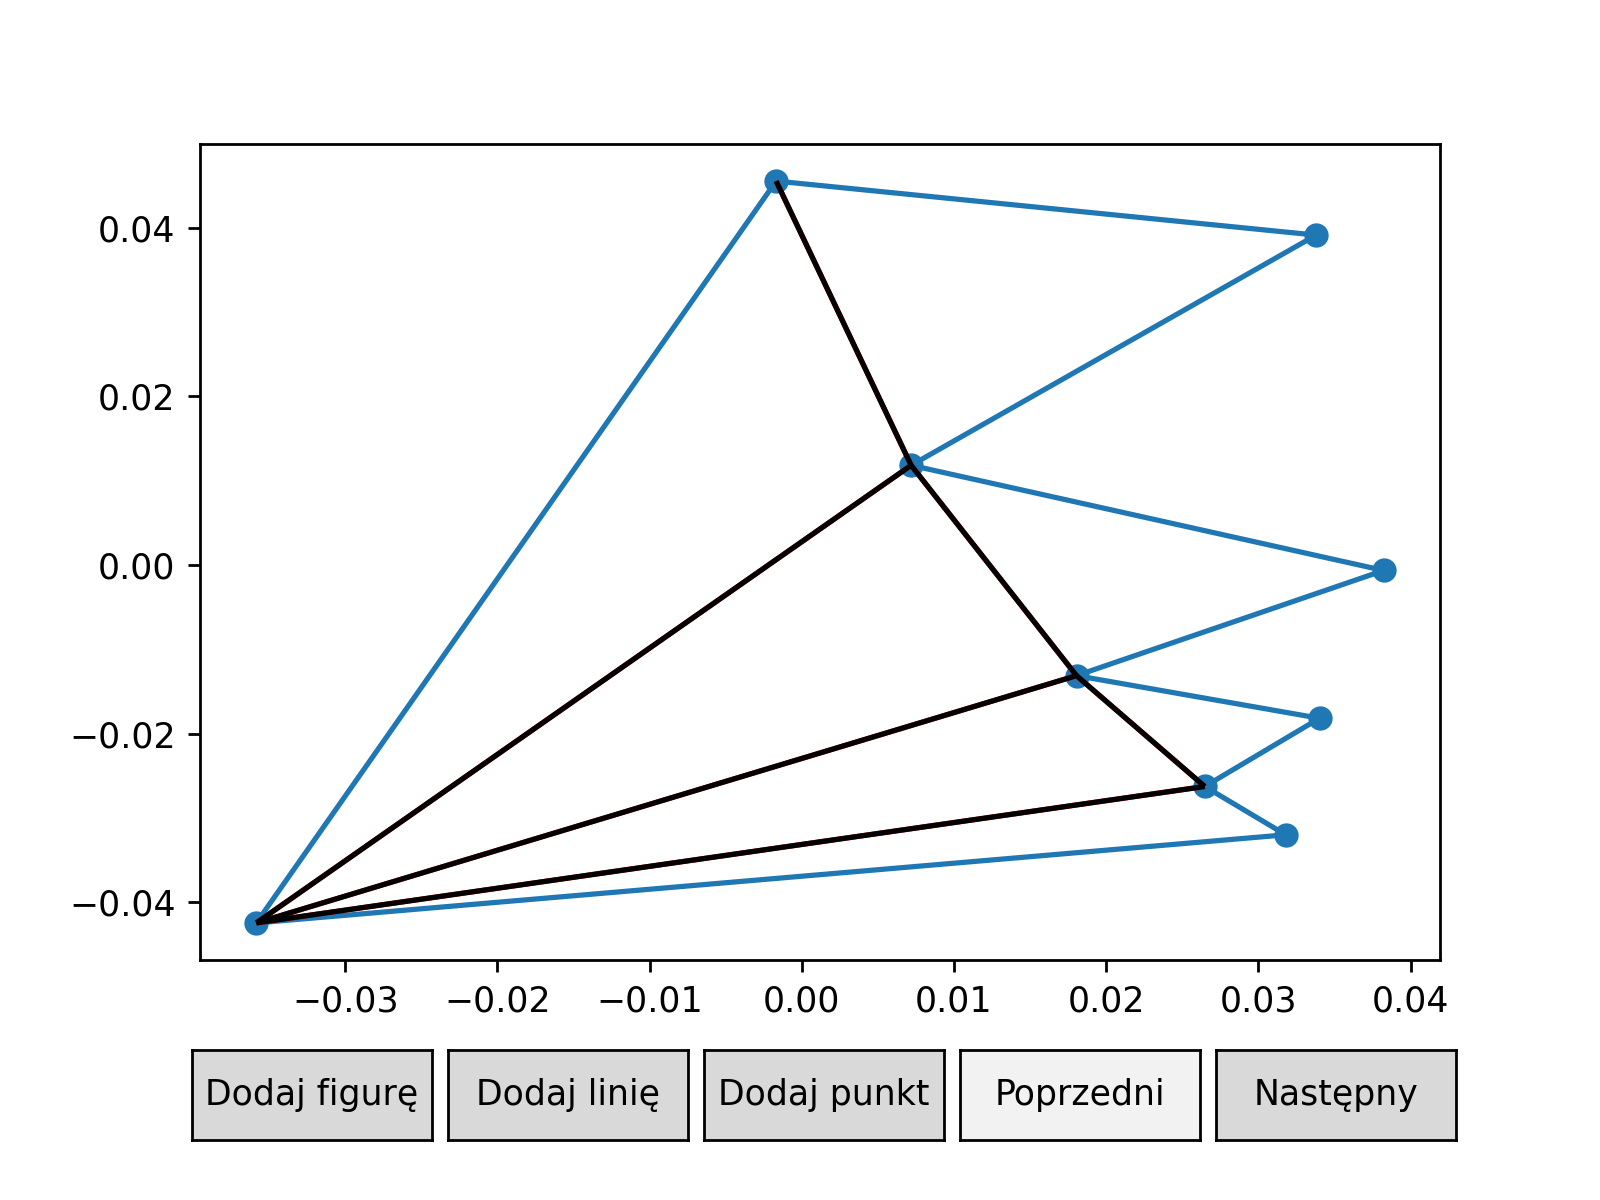

In [285]:
plot,triangels = triangulate(read_from_file('tests/test_11.txt'))
plot.draw()

<IPython.core.display.Javascript object>


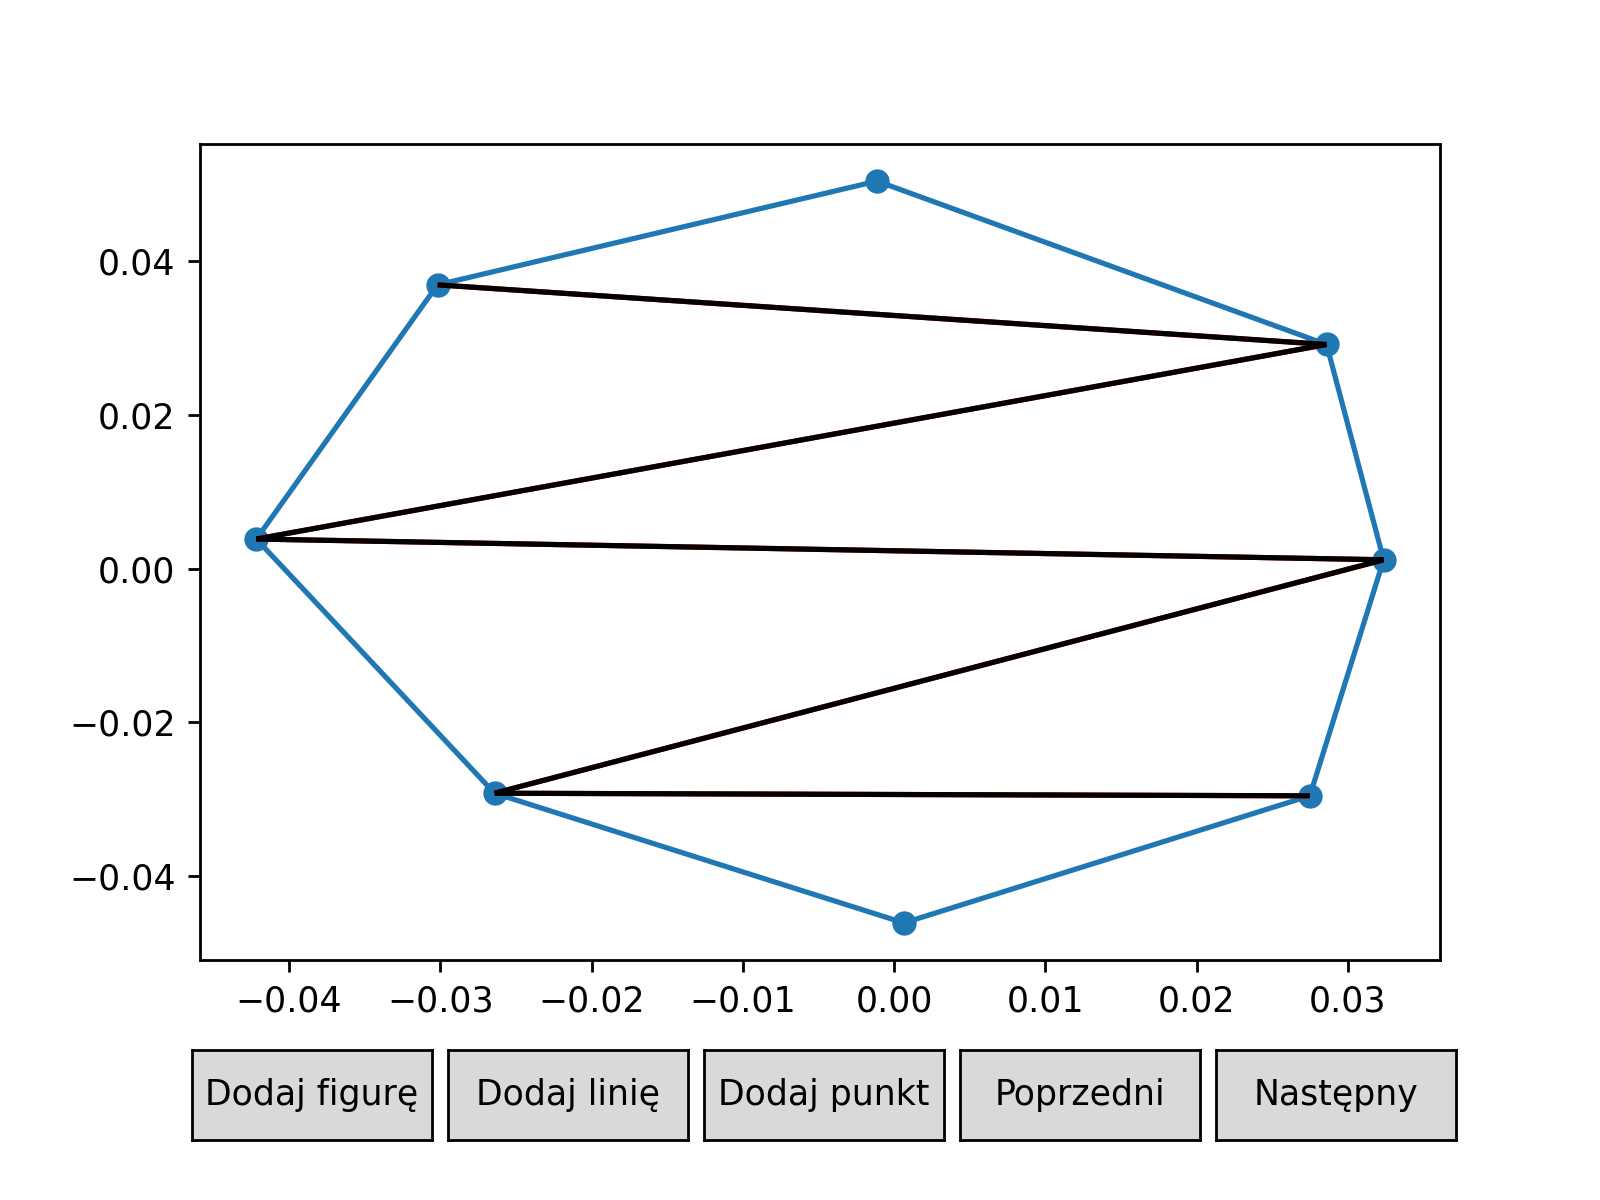

In [286]:
plot,triangels = triangulate(read_from_file('tests/test_12.txt'))
plot.draw()

<IPython.core.display.Javascript object>


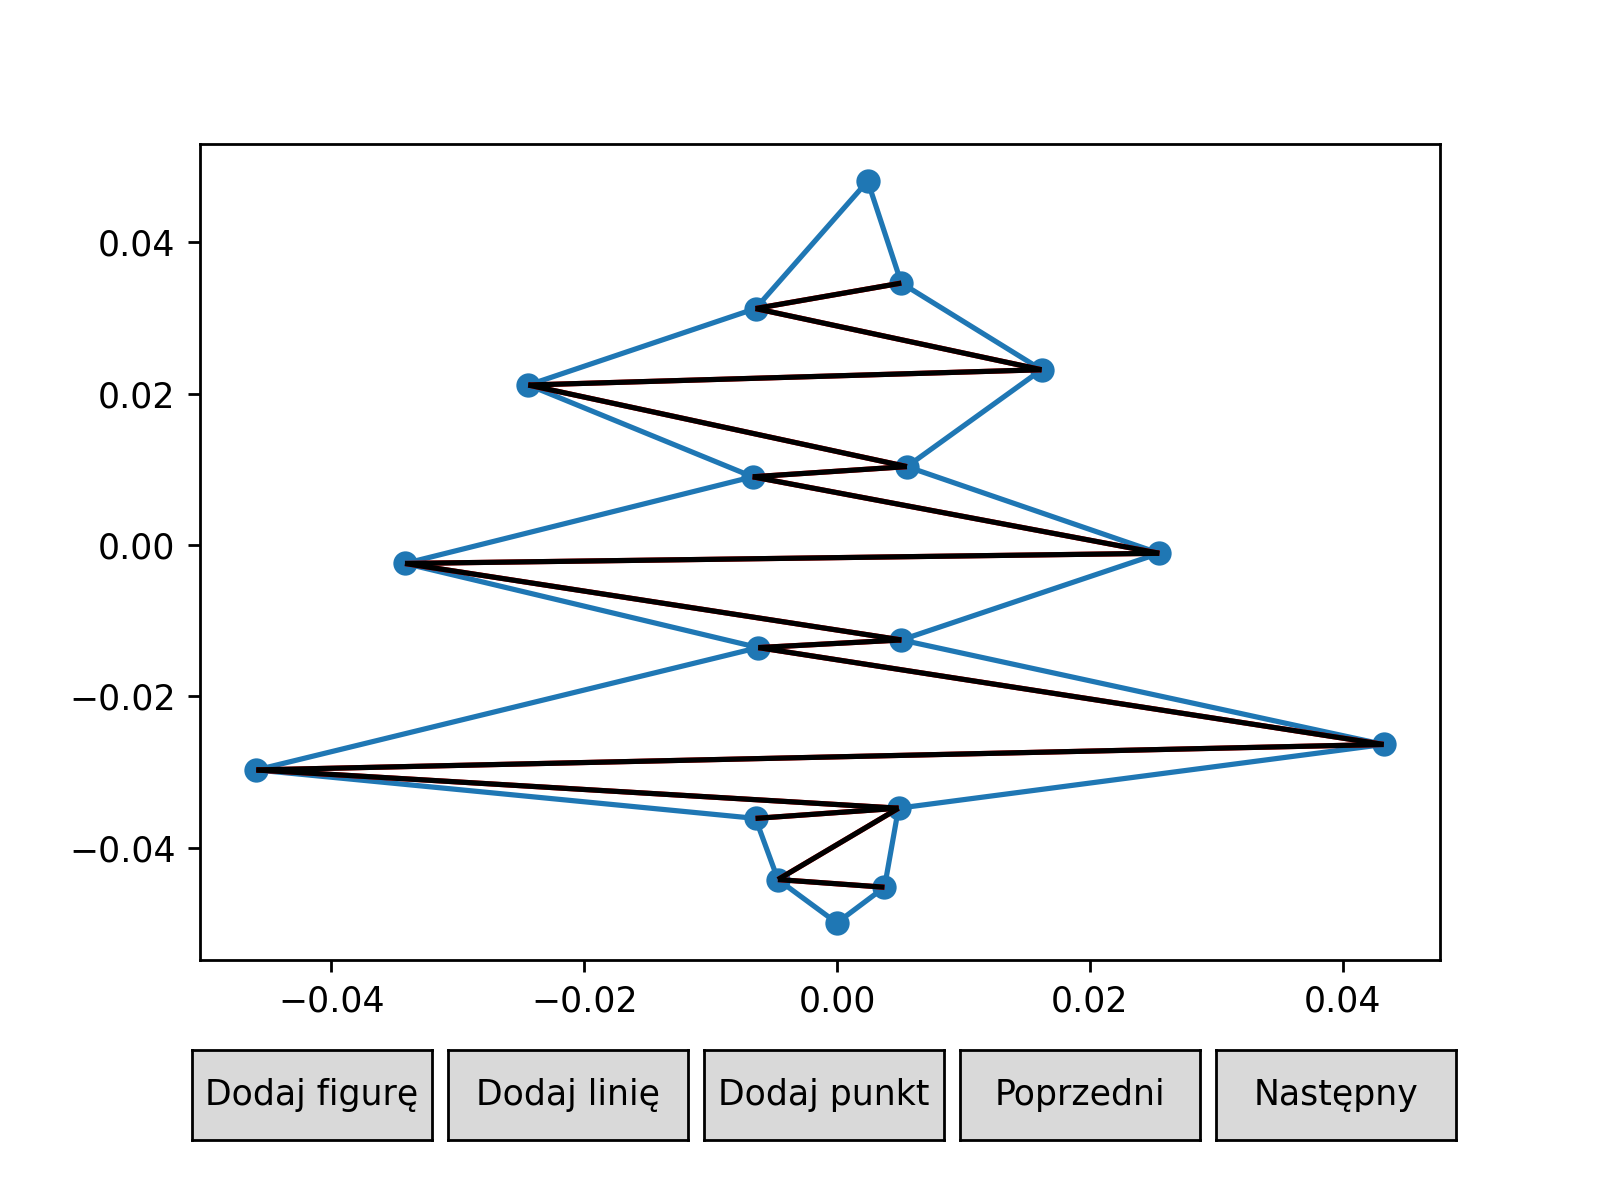

In [287]:
plot,triangels = triangulate(read_from_file('tests/test_13.txt'))
plot.draw()

<IPython.core.display.Javascript object>


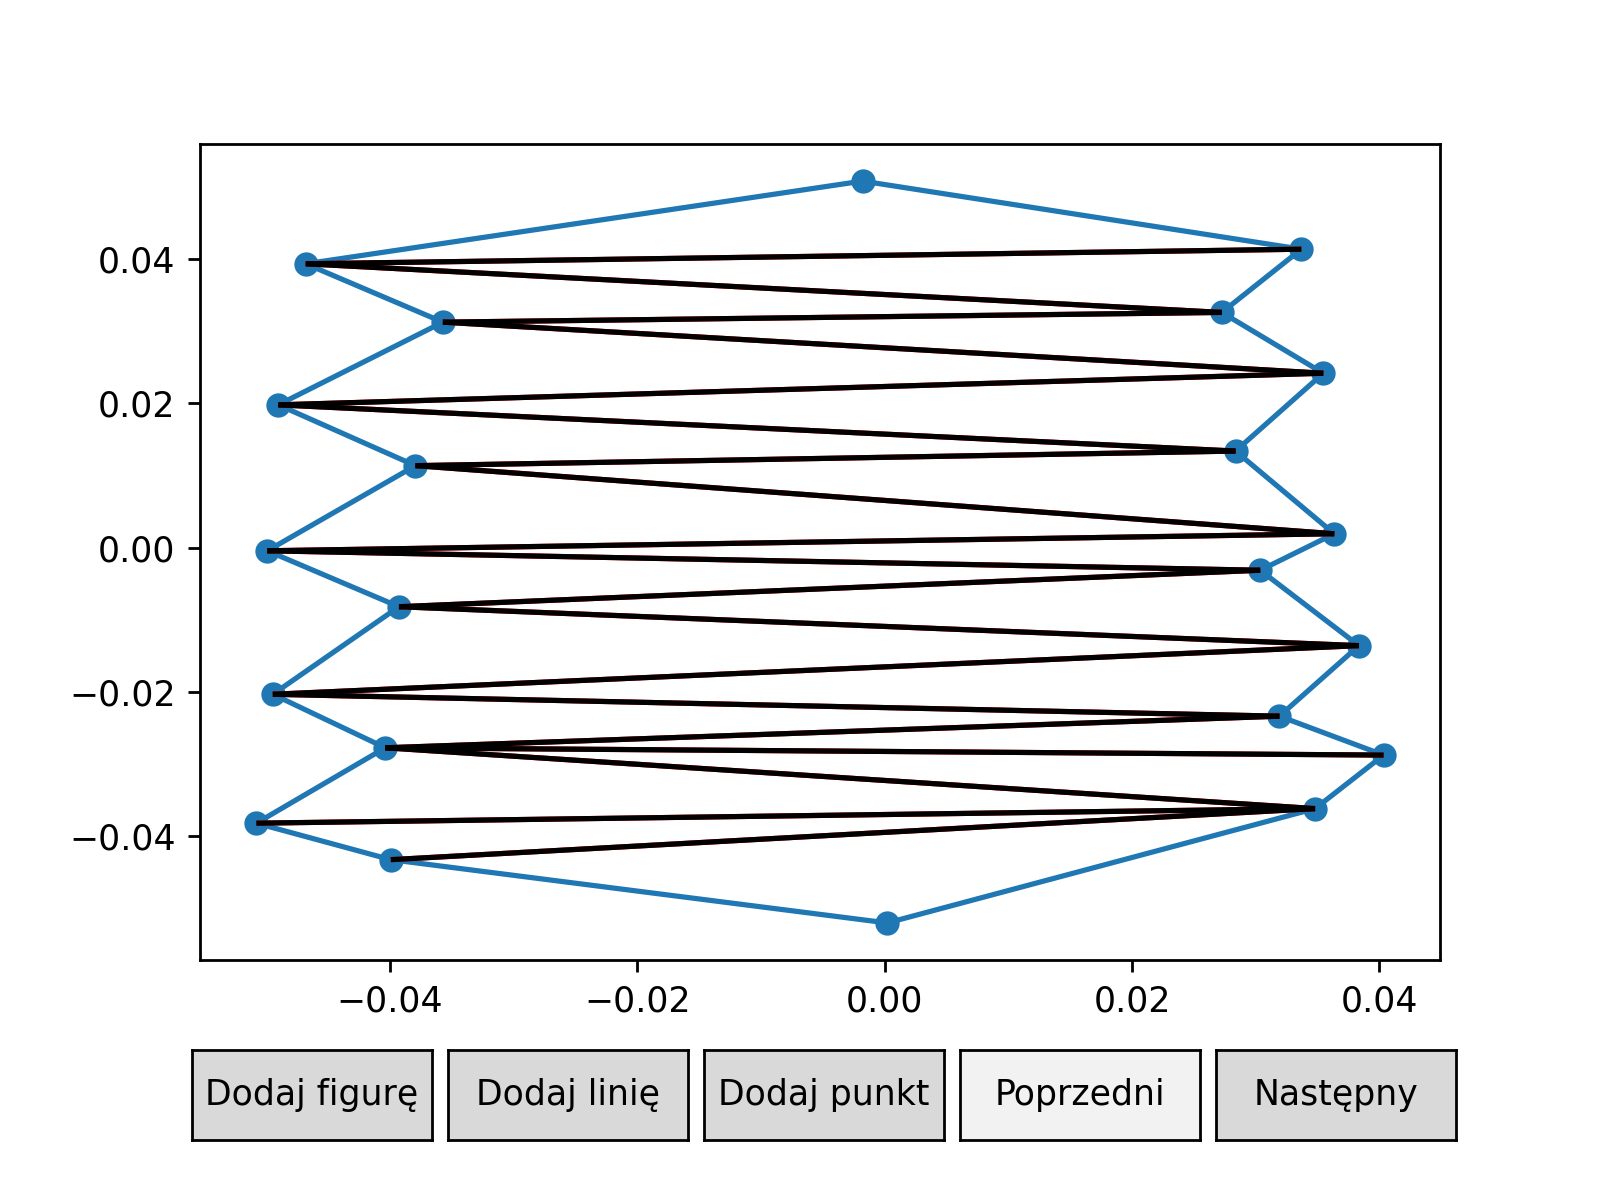

In [288]:
plot,triangels = triangulate(read_from_file('tests/test_14.txt'))
plot.draw()

<IPython.core.display.Javascript object>


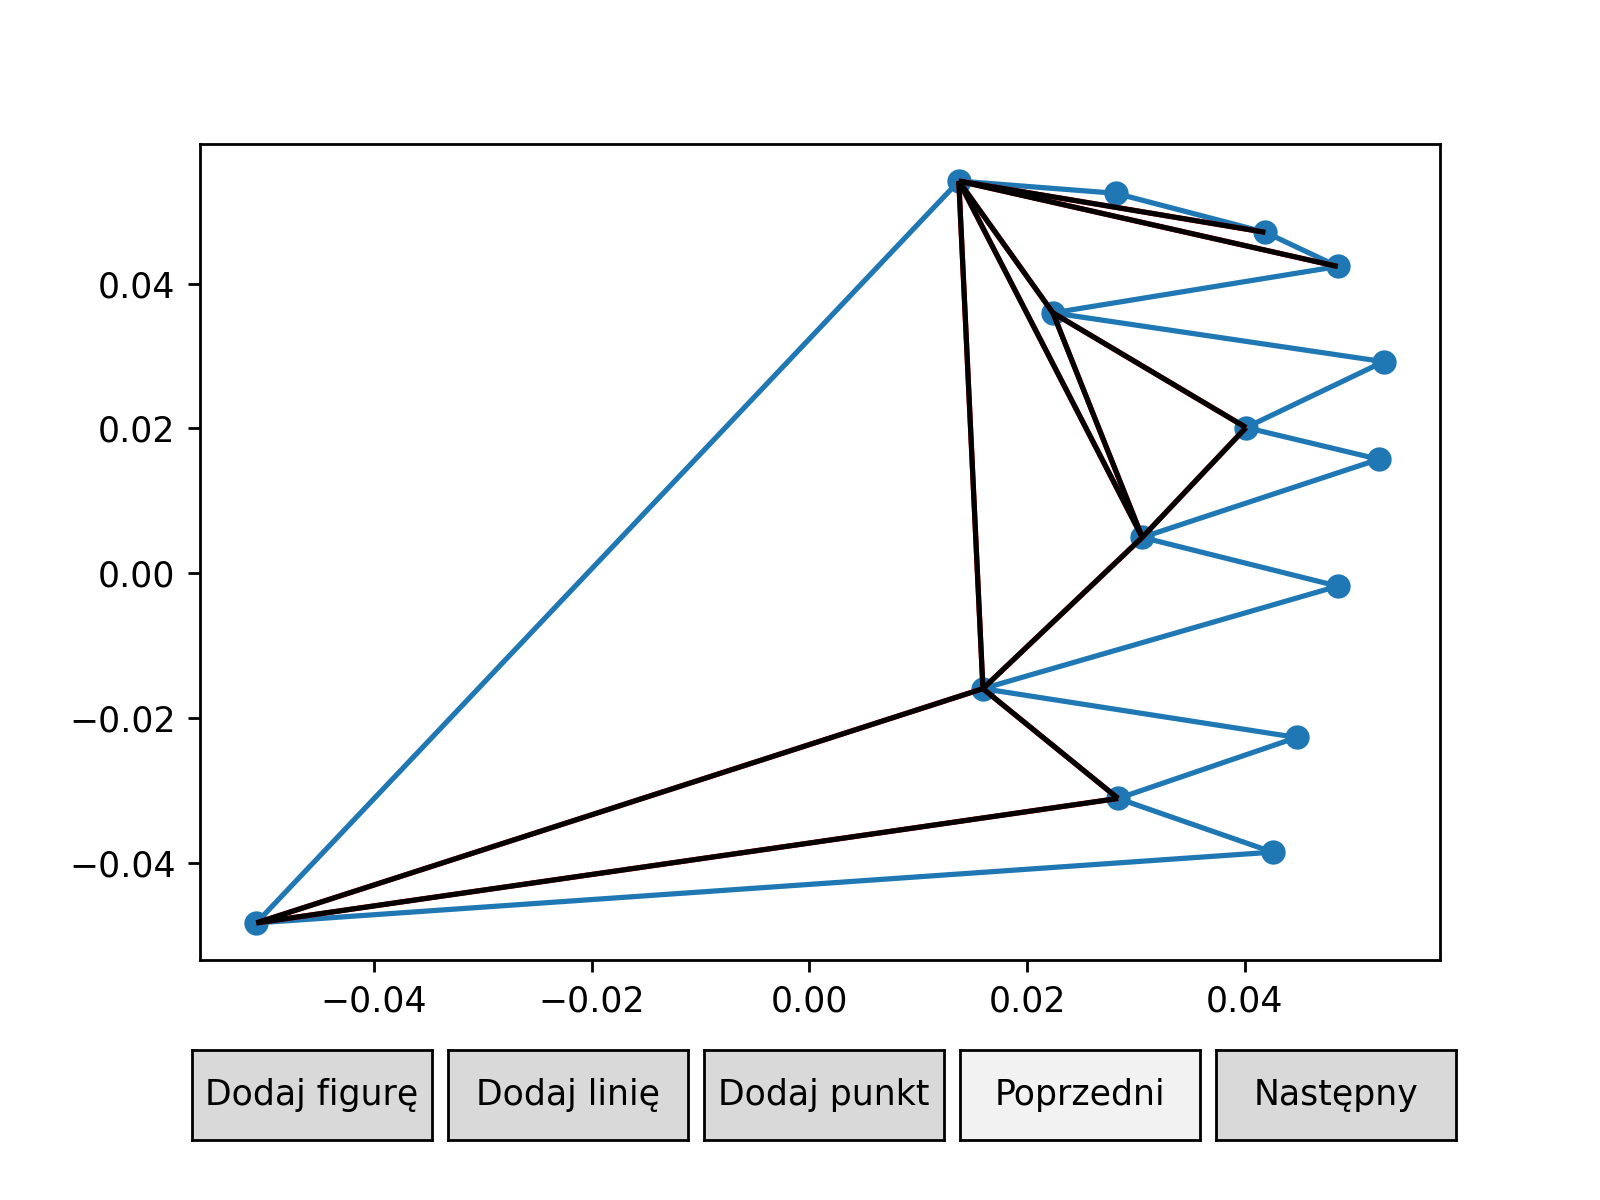

In [289]:
plot,triangels = triangulate(read_from_file('tests/test_15.txt'))
plot.draw()

# Triangulacja Delunaya

In [290]:
import matplotlib.pyplot as plt
from time import time
from collections import deque
from matplotlib.patches import Polygon

In [291]:
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.edges = set()
    
    def __hash__(self):
        return hash(self.x)*3 + hash(self.y)*5
    
    def __eq__(self,other):
        if not isinstance(other,Point):
            return False
        return self.x == other.x and self.y == other.y
    
    def __str__(self):
        return "P:("+str(self.x)+","+str(self.y)+")"
class Edge:
    def __init__(self,origin):
        self.origin = origin
        self.next = None
        self.prev = None
        self.face = None
        self.twin = None
        
    def __hash__(self):
        return hash(self.origin)*7 + hash(self.twin.origin)
    
    def __eq__(self,other):
        if not isinstance(other,Edge):
            return False
        return self.origin == other.origin and self.twin.origin == other.twin.origin
    
    def __str__(self):
        return "E: "+ str(self.origin) + " -> " + str(self.twin.origin)
class Face:
    def __init__(self,e1,e2,e3):
        self.edges = set([e1,e2,e3])
        self.visited = False
    
    def __hash__(self):
        result = 1
        for e in self.edges:
            result*=hash(e)
        return result
    
    def __eq__(self,other):
        if not isinstance(other,Face):
            return False
        if len(self.edges) != len(other.edges):
            return False
        for e in self.edges:
            if e not in other.edges:
                return False
        return True
    
    def __str__(self):
        string = "__"
        for e in self.edges:
            string = string + str(e) + " _|_ "
        return "F: " + string

    
def Orient(edge, p):
    A = edge.origin
    B = edge.twin.origin
    wynik = A.x*B.y + B.x*p.y + p.x*A.y - A.y*B.x - B.y*p.x - A.x*p.y
    if abs(wynik)<10**(-12):
        return 0
    return wynik

def pointInCircle(field, p):
    first = list(field.edges)[0]
    edges = [first,first.next,first.prev]
    #print("CONDITION")
    
    points = [edges[i].origin for i in range(3)]
    #for i in points:
    #    print(i,end = ' ')
    #print('')
    result = 0
    for i in range(3):
        result += (points[i].x - p.x)*(points[(i+1)%3].y - p.y)*(points[(i+2)%3].x**2 - p.x**2 + points[(i+2)%3].y**2 - p.y**2)
        result -= (points[i].x - p.x)*(points[(i+2)%3].y - p.y)*(points[(i+1)%3].x**2 - p.x**2 + points[(i+1)%3].y**2 - p.y**2)
    if abs(result)<10**(-12):
        return 0
    return result

def create_edge(p1,p2):
        e1 = Edge(p1)
        e2 = Edge(p2)
        e1.twin=e2
        e2.twin=e1
        p1.edges.add(e1)
        p2.edges.add(e2)
        return e1
    
def connect_edges(prev,e):
    e.prev = prev
    prev.next = e

In [292]:
def read_from_file(path):
    P = []
    read = open(path, 'r')
    for line in read:
        P.append(list(map(float, line.split())))
    return P

In [293]:
def draw_figure(L):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    for i in range(len(L)):
        plt.plot([L[i-1][0],L[i][0]],[L[i-1][1],L[i][1]],color = "blue")
        plt.plot(L[i][0], L[i][1], '.',color = 'red')

def draw_traingulation(FACES):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    for f in FACES:
        E = list(f.edges)[0]
        e = E
        
        while True:
            plt.plot([e.origin.x,e.twin.origin.x],[e.origin.y,e.twin.origin.y],color = "blue")
            plt.plot(e.origin.x,e.origin.y,'.',color = 'red',markersize = 10)
            e = e.next
            if e == E:
                break
    return ax

In [294]:
class Delunay:
    def __init__(self,T):
        ## 1
        self.FACES = set()
        self.Points = [Point(p[0],p[1]) for p in T]
        
        min_x = min([p.x for p in self.Points])
        min_y = min([p.y for p in self.Points])
        max_x = max([p.x for p in self.Points])
        max_y = max([p.y for p in self.Points])
        self.middle = Point((max_x+min_x)/2,(max_y+min_y)/2)
        width = max_x - min_x
        min_x -= width*0.1
        max_x += width*0.1
        height = max_y - min_y
        min_y -= height*0.1
        max_y += height*0.1
        A = Point(min_x,min_y)
        B = Point(max_x,min_y)
        C = Point(max_x,max_y)
        D = Point(min_x,max_y)
        self.startingPoints = [A,B,C,D]
        ## 2
        e1 = create_edge(A,B)
        e2 = create_edge(B,C)
        e3 = create_edge(C,A)
        T = [e1,e2,e3]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e2.twin,e1.twin)
        # ---------------
        self.middleFace = self.create_face(T)
        # ---------------
        e4 = create_edge(C,D)
        e5 = create_edge(D,A)
        T = [e3.twin,e4,e5]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e1.twin,e5.twin)
        connect_edges(e5.twin,e4.twin)
        connect_edges(e4.twin,e2.twin)
        
        self.create_face(T)
    
    def create_face(self,edges):
        face = Face(edges[0],edges[1],edges[2])
        for i in range(3):
            edges[i].face = face
        self.FACES.add(face)
        return face
    
    def pointInFace(self,face,p):
        for e in face.edges:
            if Orient(e, p)<0:
                return False
        return True
        
    def findPoint(self,p):
        face = self.middleFace  #  na później
        while True:
            flag = True
            for e in face.edges:
                if Orient(e, p)<0:
                    face = e.twin.face
                    flag = False
                    break
            if flag:
                break
        return face
    
    # Face musi miec pole VISITED
    def conditionFaces(self,p, face):
        faces = set()
        for f in self.FACES:
            f.visited = False
        Q = deque()
        Q.append(face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            face.visited = True
            if pointInCircle(face, p)>=0:
                faces.add(face)
                for e in face.edges:
                    if e.twin.face!=None and not e.twin.face.visited:
                        Q.append(e.twin.face)
        return faces
                
    #
    def combineFaces(self,faces):
        edges = set()
        for face in faces:
            if face == self.middleFace:
                self.middleFace = None
            edges.update(face.edges)
            self.FACES.remove(face)
        while len(edges) > 0:
            e = edges.pop()
            #print(e,e.twin in edges)
            if e.twin in edges:
                # usuwanie krawedzi
                e.twin.prev.next = e.next
                e.next.prev = e.twin.prev
                e.twin.next.prev = e.prev
                e.prev.next = e.twin.next
                edges.remove(e.twin)
                e.origin.edges.remove(e)
                e.twin.origin.edges.remove(e.twin)
            else:
                firstEdge = e
        return firstEdge
        
    #
    #face mhsi miec KRAWEDZIE, bo inaczej nie vedzie sie dalo dojsc z punktu do krawedzi (nie bedzie jednoznacznego okreslenia w ktore krawiedzie sa)
    def add_point(self,p): #zmiana, lecimy druga metoda
        plt.show()
        face = self.findPoint(p)
        
        faces = self.conditionFaces(p,face) # to ma być set zwrocony

        firstEdge=self.combineFaces(faces) # a tutaj jedna krawędź
        lastEdge = firstEdge.prev
            
        q = firstEdge.origin
        e = create_edge(p,q)
        e.next = firstEdge
        e.twin.prev = lastEdge #obaczymy czy trgo nie robie pozniei
        lastEdge.next = e.twin
        firstEdge.prev = e
        f = firstEdge.next
        while True:
            q = f.origin
                #podczepianie krawedzi
            e = create_edge(p,q)
            e.next = f
            e.twin.prev = f.prev 
            e.twin.next= e.twin.prev.prev
            e.twin.next.prev = e.twin     ########## TO OSTATNIE DOPISAŁEM
            #e.twin.next.prev = e.twin
            f.prev.next = e.twin
            f.prev = e
                #podczepianie sciany
            et = e.twin
            T = [et, et.next, et.prev]
            newFace = self.create_face(T)
            if self.middleFace == None:
                if self.pointInFace(newFace,self.middle):
                    self.middleFace = newFace
            if f == lastEdge:
                break
            f = f.next
        e.prev = lastEdge.next 
        e.prev.next = e
        T = [e, e.next, e.prev]
        
        newFace = self.create_face(T)
        if self.middleFace == None:
            if self.pointInFace(newFace,self.middle):
                self.middleFace = newFace
        
    def addPoints(self,steps):
        for p in self.Points: 
            self.add_point(p)
            if steps:
                draw_traingulation(self.FACES)
            
    def addPointsRandom(self,steps):
        POINTS = set(self.Points)
        while len(POINTS)>0:
            self.add_point(POINTS.pop())
            if steps:
                draw_traingulation(self.FACES)
                plt.show()
                
    # ----------------------
    
    def intersecting_edge(self,face,p,pnext):
        C,D = p, pnext
        edge2 = Edge(C)
        edge2.twin = Edge(D)
        for edge in face.edges:
            A = edge.origin
            B = edge.twin.origin
            if Orient(edge,C)*Orient(edge,D) > 0:
                continue
            if Orient(edge2,A)*Orient(edge2,B) <= 0:
                return edge
        return False
            
    def regainEdges(self,steps = False):
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            #print("p i next:  ",p,pnext)
            flag = False
            for e in p.edges:
                if e.twin in pnext.edges:
                    flag = True
                    break
            if not flag:
                
                dx = pnext.x - p.x
                dy = pnext.y - p.y
                lenght = dx**2+dy**2
                t = 10**(-8)
                pierw = 1
                while pierw*pierw<lenght:
                    pierw*=10
                    t/=10
                firstSearchPoint = Point(p.x+t*dx,p.y+t*dy)
                face = self.findPoint(firstSearchPoint)
                br = False
                while not br:
                    int_e = self.intersecting_edge(face, firstSearchPoint, pnext)
                    if int_e.face == self.middleFace or int_e.twin.face== self.middleFace:
                        self.middleFace = None
                    self.FACES.remove(int_e.face)
                    self.FACES.remove(int_e.twin.face)
                    
                    # usuniecie z punktow
                    int_e.origin.edges.remove(int_e)
                    int_e.twin.origin.edges.remove(int_e.twin)
                    
                    # usuniecie z sasiednich krawedzi
                    int_e.next.prev = int_e.twin.prev
                    int_e.prev.next = int_e.twin.next
                    int_e.twin.prev.next = int_e.next
                    int_e.twin.next.prev = int_e.prev

                    #tworzenie nowej
                    e1 = create_edge(int_e.prev.origin,int_e.twin.prev.origin)
                    
                    #podłaczanie
                    e1.origin.edges.add(e1)
                    e1.twin.origin.edges.add(e1.twin)
                    
                    # krawedzie
                    int_e.next.next = e1
                    e1.prev = int_e.next
                    int_e.twin.prev.prev = e1
                    e1.next = int_e.twin.prev
                    int_e.prev.prev = e1.twin
                    e1.twin.next = int_e.prev
                    int_e.twin.next.next = e1.twin
                    e1.twin.prev = int_e.twin.next
                    face1 = self.create_face([e1,e1.next,e1.prev])
                    face2 = self.create_face([e1.twin,e1.twin.next,e1.twin.prev])
                    if self.middleFace == None:
                        if self.pointInFace(face1,self.middle):
                            self.middleFace = face1
                        else:
                            self.middleFace = face2
                    face = e1.face
                    if self.intersecting_edge(face, firstSearchPoint, pnext) == False:
                        face = e1.twin.face
                    for e in p.edges:
                        if e.twin in pnext.edges:
                            br = True
                            break
                    if steps:
                        draw_traingulation(self.FACES)
                        plt.plot([int_e.origin.x,int_e.twin.origin.x],[int_e.origin.y,int_e.twin.origin.y],color = 'red')
                        plt.plot([e1.origin.x,e1.twin.origin.x],[e1.origin.y,e1.twin.origin.y],color = 'green')
                        plt.plot([p.x,pnext.x],[p.y,pnext.y],'--',color = "black")
                        plt.show()
                    
    def eraseOuterLayer(self,steps):
        def safe_create_edge(p,pnext):
            e1 = Edge(p)
            e2 = Edge(pnext)
            e1.twin = e2
            e2.twin = e1
            return e1
        EDGES = set()
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            e = safe_create_edge(p,pnext)
            EDGES.add(e)
        point = self.Points[0]
        for f in self.FACES:
            f.visited = False
        for e in point.edges:
            if e in EDGES:
                break
        Q = deque()
        Q.append(e.face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            if steps:
                ax = draw_traingulation(self.FACES)
                for f in self.FACES:
                    if f.visited:
                        pts = [[edge.origin.x,edge.origin.y] for edge in f.edges]
                        p = Polygon(pts, closed=False)
                        ax.add_patch(p)
                for edge in EDGES:
                    plt.plot([edge.origin.x,edge.twin.origin.x],[edge.origin.y,edge.twin.origin.y],linewidth = 5,color = 'black')
                pts = [[edge.origin.x,edge.origin.y] for edge in face.edges]
                p = Polygon(pts, closed=False,color = 'red')
                ax.add_patch(p)
                plt.show()
            face.visited = True
            for e in face.edges:
                if e not in EDGES and not e.twin.face.visited:
                    Q.append(e.twin.face)
        AllFaces = list(self.FACES)
        for face in AllFaces:
            #print(face)
            if face.visited:
                continue
            # usuwanie sciany
            for e in face.edges:
                e.next = None
                e.prev = None
                e.face = None
            self.FACES.remove(face)
    
    def start(self,Steps,random):
        if Steps:
            draw_traingulation(self.FACES)
            print("ADD")
        if random:
            self.addPointsRandom(steps = Steps)
        else:
            self.addPoints(steps = Steps)
        if Steps:
            print("REGAIN")
        self.regainEdges(steps = Steps)
        if Steps:
            draw_traingulation(self.FACES)
            plt.show()
            print("ERASE")
        self.eraseOuterLayer(steps = Steps)
        draw_traingulation(self.FACES)
        plt.show()

### URUCHAMIANIE TRIANGULACJI DELUNAYA

Nazwa pliku:test_1
with steps? [Y/N]: N


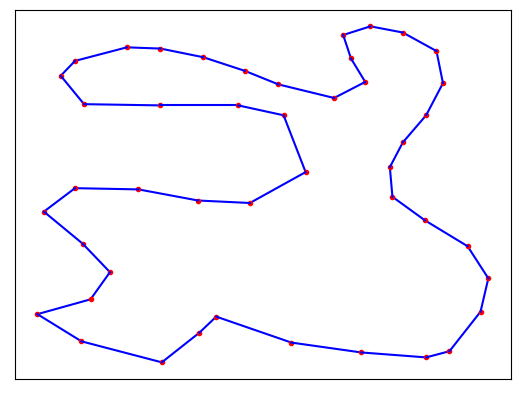

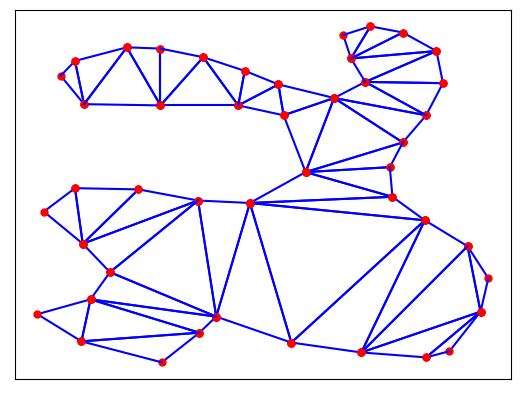

In [296]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_2
with steps? [Y/N]: N


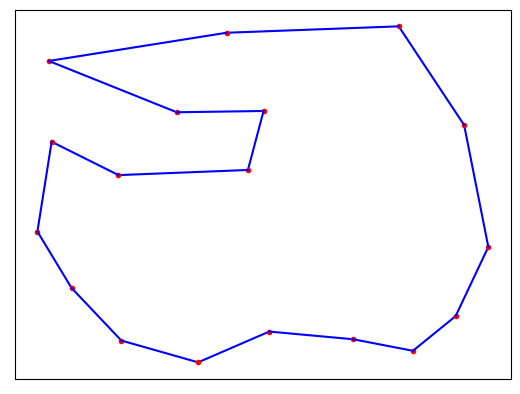

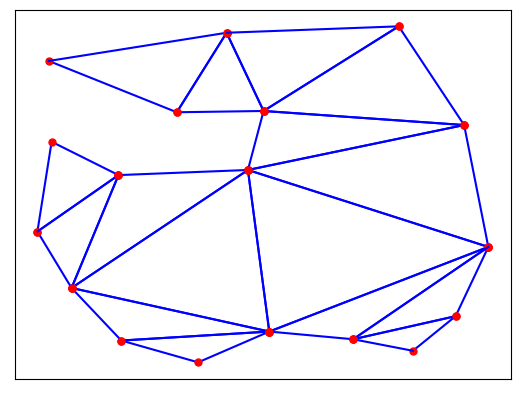

In [297]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_3
with steps? [Y/N]: N


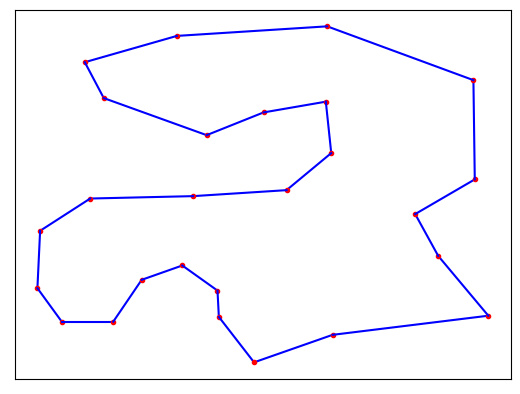

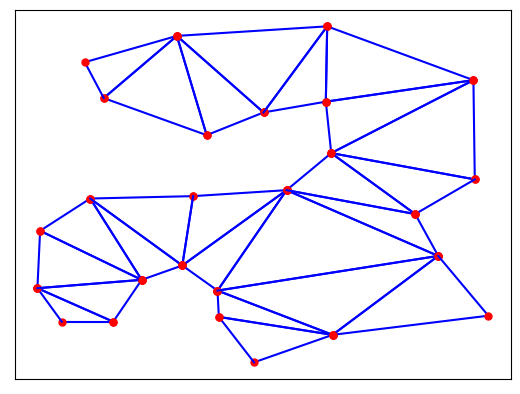

In [298]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()


Nazwa pliku:test_4
with steps? [Y/N]: N


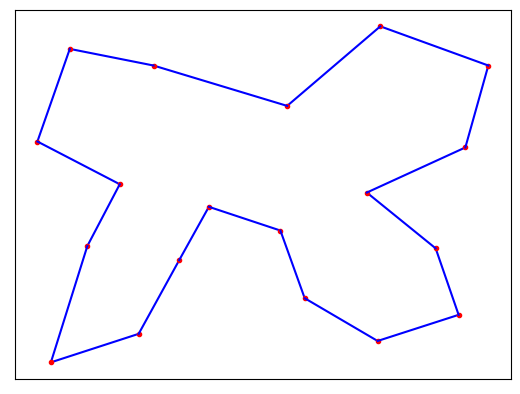

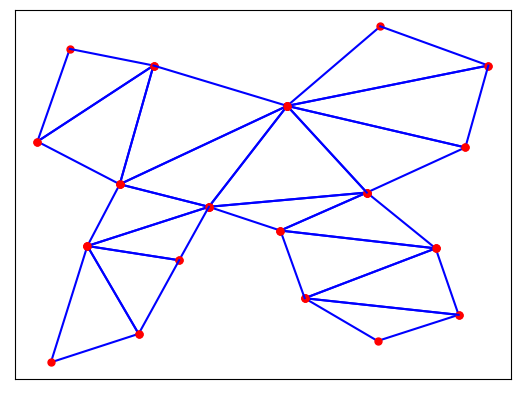

In [299]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_5
with steps? [Y/N]: N


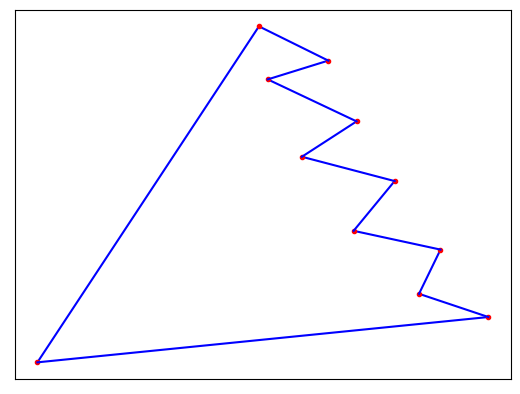

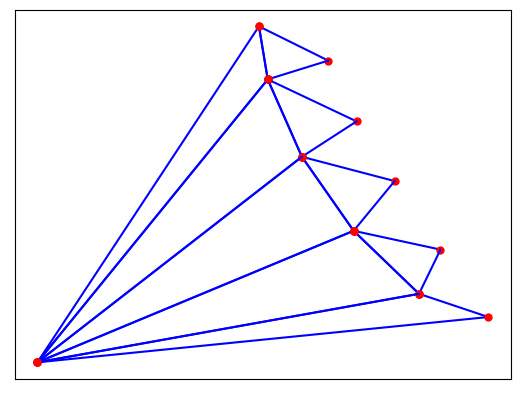

In [300]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_6
with steps? [Y/N]: N


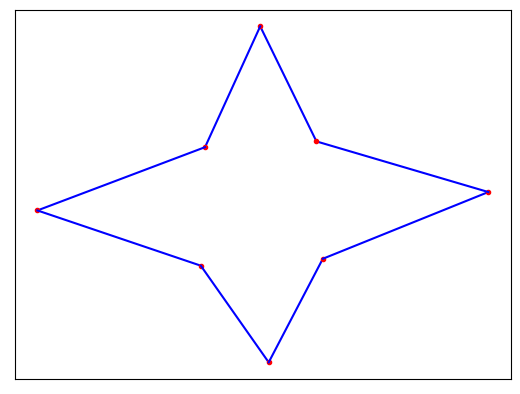

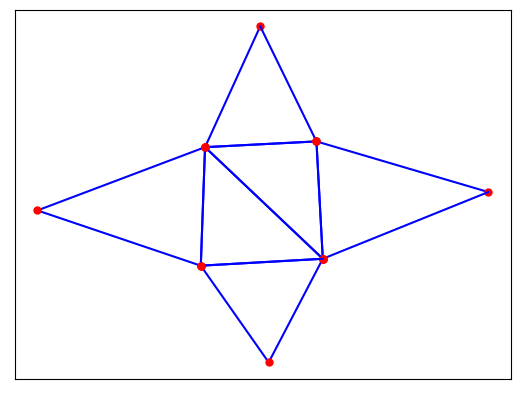

In [301]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_7
with steps? [Y/N]: N


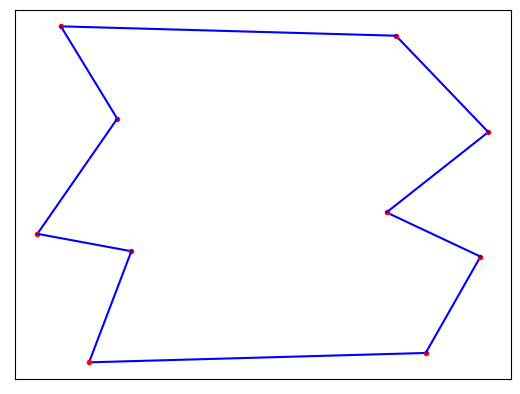

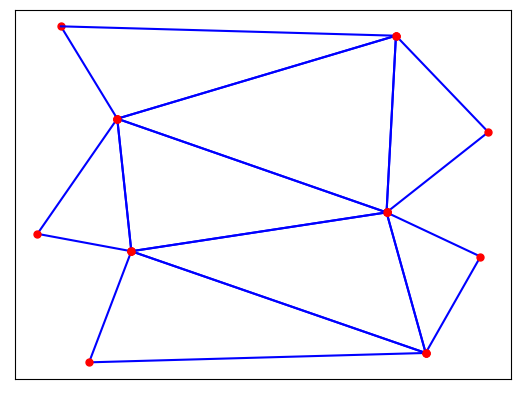

In [302]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_10
with steps? [Y/N]: N


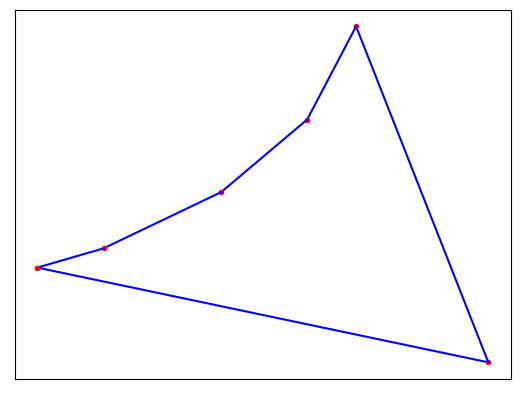

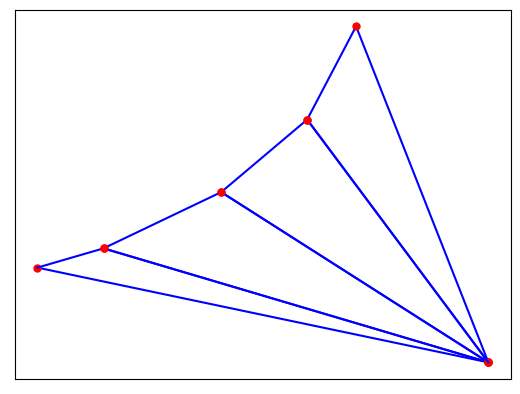

In [303]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_11
with steps? [Y/N]: N


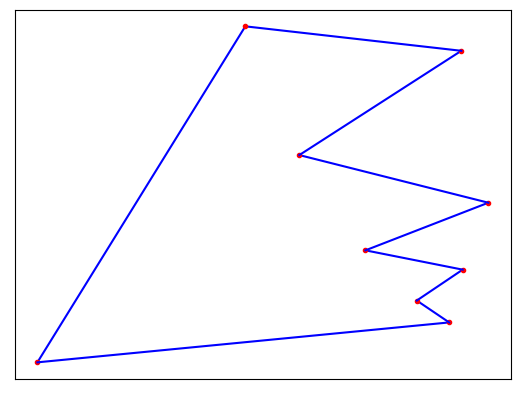

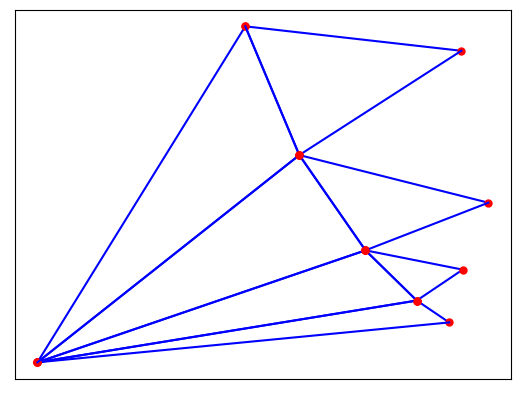

In [304]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_12
with steps? [Y/N]: N


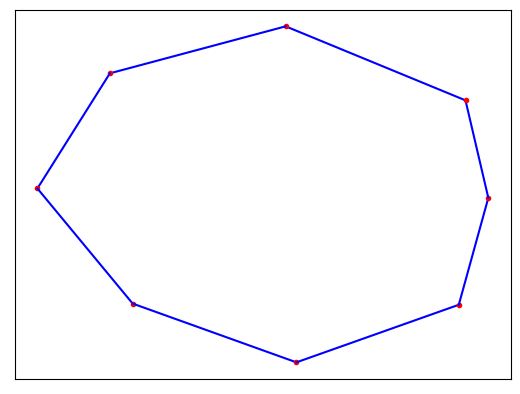

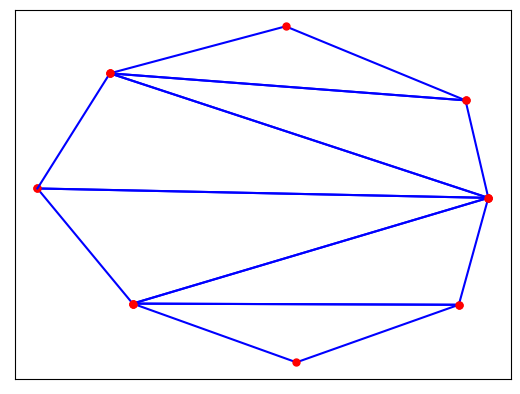

In [305]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_14
with steps? [Y/N]: N


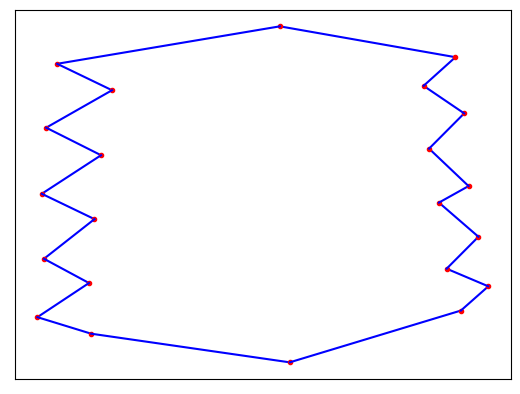

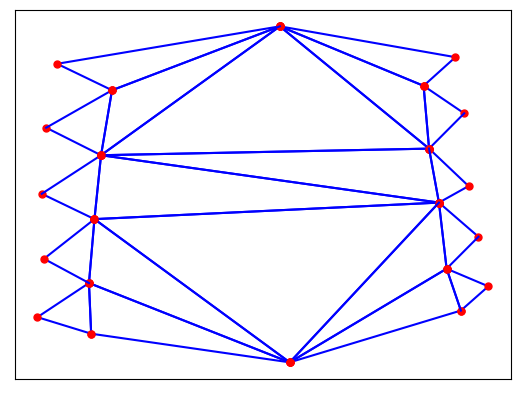

In [306]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

Nazwa pliku:test_15
with steps? [Y/N]: N


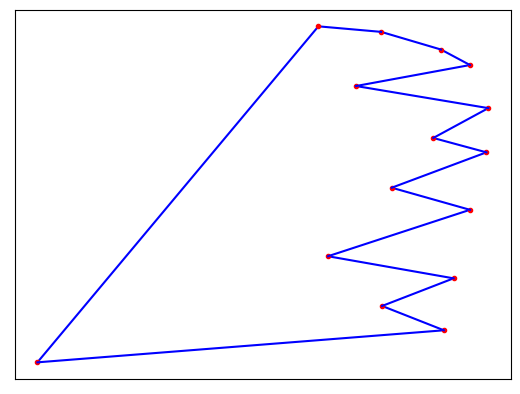

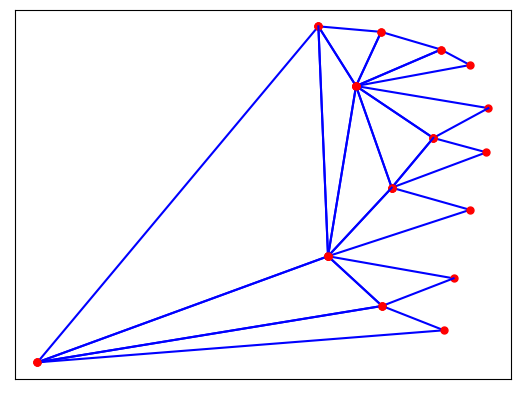

In [307]:
%matplotlib inline
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()